# Mini Project: Leveraging ML for Revenue Optimization via Strategic Couponing

## Objective
We develop a predictive model that decides whether a customer should receive a **€5 voucher** after their first purchase.  
The goal is to maximize **expected revenue**.

### Business payoff structure (given)
- If we **send a voucher** to a customer who **would not reorder** (true churn), then in **25%** of cases the voucher triggers a purchase with **€10** average order value  
  ⇒ the net uplift is **€1.25** per such customer.
- If we **send a voucher** to a customer who **would reorder anyway**, we lose **€5** (discount we did not need to give).
- If we **do not send** a voucher, revenue impact is **€0**.

Therefore, we will optimize the model and its decision threshold directly for **expected revenue**.

Name : Franzi Nagel
Name : Alexander Unger

# 1. Data inspection

## 1.1 Load training data

We load the training dataset and verify shape, schema, and the target definition.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if np.version.version.startswith('1.'):
    print("✅ SUCCESS: You are on the stable NumPy 1.x. Pandas will work perfectly!")
else:
    print("❌ CAUTION: You are still on NumPy 2.x. This might cause the error.")

✅ SUCCESS: You are on the stable NumPy 1.x. Pandas will work perfectly!


In [2]:
import os

my_dire = os.getcwd()
train = pd.read_csv('train.csv', sep=';')

C:\Users\Franzi\AppData\Local\Temp\ipykernel_14032\2933119078.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv', sep=';')


## 1.2 Feature dictionary check

We compare observed columns to the data dictionary to detect missing or unexpected fields early.


In [3]:
train.columns.tolist()
train.dtypes

customernumber           int64
date                    object
salutation               int64
title                    int64
domain                   int64
datecreated             object
newsletter               int64
model                    int64
paymenttype              int64
deliverytype             int64
invoicepostcode          int64
delivpostcode           object
voucher                  int64
advertisingdatacode     object
case                     int64
numberitems              int64
gift                     int64
entry                    int64
points                   int64
shippingcosts            int64
deliverydatepromised    object
deliverydatereal        object
weight                   int64
remi                     int64
cancel                   int64
used                     int64
w0                       int64
w1                       int64
w2                       int64
w3                       int64
w4                       int64
w5                       int64
w6      

## 1.3 Target distribution

Since business value is asymmetric, we inspect class balance but optimize later for expected revenue.


In [4]:
target_col = "target90"
train[target_col].value_counts(dropna=False), train[target_col].mean()


(target90
 0    26377
 1     6051
 Name: count, dtype: int64,
 0.1865980017269027)

## 1.4 Missing values overview

We quantify missingness to guide feature engineering and imputation decisions.


In [5]:
missing = train.isna().mean().sort_values(ascending=False)
missing[missing > 0].head(30)


delivpostcode          0.957074
advertisingdatacode    0.798847
dtype: float64

In [6]:
train.isna().sum().sort_values(ascending=False)


delivpostcode           31036
advertisingdatacode     25905
customernumber              0
deliverydatepromised        0
weight                      0
remi                        0
cancel                      0
used                        0
w0                          0
w1                          0
w2                          0
w3                          0
w4                          0
w5                          0
w6                          0
w7                          0
w8                          0
w9                          0
w10                         0
deliverydatereal            0
shippingcosts               0
date                        0
paymenttype                 0
salutation                  0
title                       0
domain                      0
datecreated                 0
newsletter                  0
model                       0
deliverytype                0
points                      0
invoicepostcode             0
voucher                     0
case      

## 1.5 Basic integrity checks

We run lightweight checks to catch impossible values and potential data issues before modeling.


In [7]:
checks = {
    "negative_weight": (train["weight"] < 0).sum() if "weight" in train.columns else None,
    "negative_numberitems": (train["numberitems"] < 0).sum() if "numberitems" in train.columns else None,
    "negative_remi": (train["remi"] < 0).sum() if "remi" in train.columns else None,
    "negative_cancel": (train["cancel"] < 0).sum() if "cancel" in train.columns else None,
    "negative_used": (train["used"] < 0).sum() if "used" in train.columns else None,
}
checks


{'negative_weight': 0,
 'negative_numberitems': 0,
 'negative_remi': 0,
 'negative_cancel': 0,
 'negative_used': 0}

## 1.6 Date parsing

We convert date-like columns to datetime to enable duration features and consistency checks.


In [8]:
# Example: account created should not be after first order (if both exist)
if "date" in train.columns and "datecreated" in train.columns:
    invalid_account_age = (train["date"] < train["datecreated"]).sum()
    invalid_account_age


## 1.7 Univariate EDA (light)

We summarize numeric variables and inspect a small set of distributions to identify skew and outliers.


In [9]:
num_cols = train.select_dtypes(include=[np.number]).columns
train[num_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
customernumber,32428.0,33389.298569,19148.090449,1.0,16802.75,33552.5,50034.25,66251.0
salutation,32428.0,0.541569,0.657044,0.0,0.00,0.0,1.00,2.0
title,32428.0,0.006969,0.083192,0.0,0.00,0.0,0.00,1.0
domain,32428.0,7.517115,3.683945,0.0,4.00,9.0,11.00,12.0
newsletter,32428.0,0.169483,0.375184,0.0,0.00,0.0,0.00,1.0
model,32428.0,1.646910,0.825981,1.0,1.00,1.0,2.00,3.0
paymenttype,32428.0,1.000987,1.092677,0.0,0.00,1.0,2.00,3.0
deliverytype,32428.0,0.201955,0.401465,0.0,0.00,0.0,0.00,1.0
invoicepostcode,32428.0,48.752282,24.361425,0.0,30.00,47.0,66.00,99.0
voucher,32428.0,0.162020,0.368475,0.0,0.00,0.0,0.00,1.0


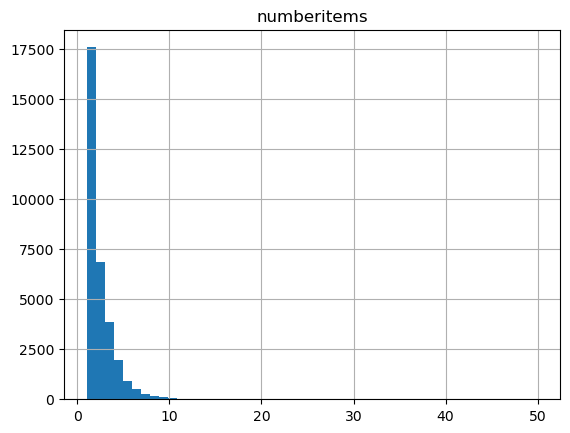

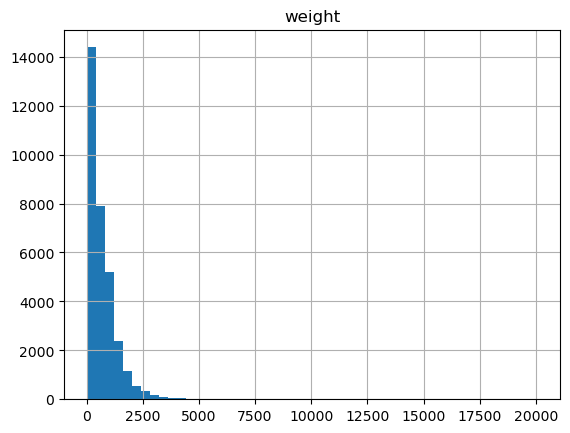

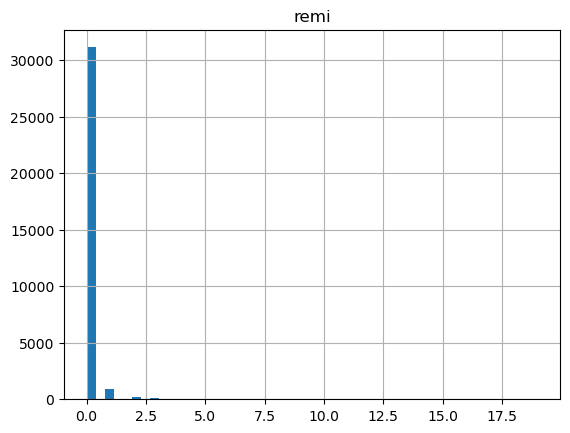

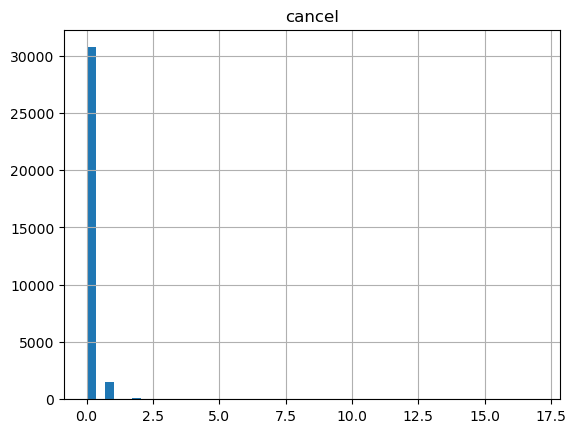

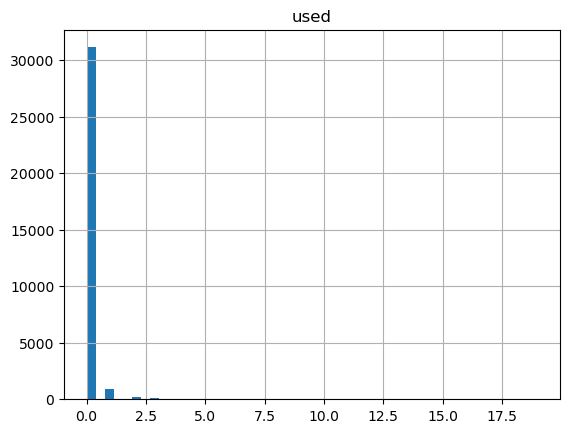

In [10]:
plot_cols = [c for c in ["numberitems", "weight", "remi", "cancel", "used"] if c in train.columns]

for c in plot_cols:
    plt.figure()
    train[c].hist(bins=50)
    plt.title(c)
    plt.show()


## 1.8 Categorical checks

We inspect low-cardinality categorical variables to confirm coding and spot rare categories.


In [11]:
cat_candidates = ["salutation", "title", "newsletter", "model", "paymenttype", "deliverytype", "voucher", "gift", "entry", "points", "shippingcosts", "domain", "case"]
for c in [x for x in cat_candidates if x in train.columns]:
    print("\n", c)
    print(train[c].value_counts(dropna=False).head(20))



 salutation
salutation
0    17840
1    11614
2     2974
Name: count, dtype: int64

 title
title
0    32202
1      226
Name: count, dtype: int64

 newsletter
newsletter
0    26932
1     5496
Name: count, dtype: int64

 model
model
1    18808
3     7358
2     6262
Name: count, dtype: int64

 paymenttype
paymenttype
0    15063
1     6549
2     6537
3     4279
Name: count, dtype: int64

 deliverytype
deliverytype
0    25879
1     6549
Name: count, dtype: int64

 voucher
voucher
0    27174
1     5254
Name: count, dtype: int64

 gift
gift
0    32280
1      148
Name: count, dtype: int64

 entry
entry
0    18982
1    13446
Name: count, dtype: int64

 points
points
0    32428
Name: count, dtype: int64

 shippingcosts
shippingcosts
0    27544
1     4884
Name: count, dtype: int64

 domain
domain
12    7734
9     6953
4     6627
8     3694
11    1422
5     1311
2     1196
0     1173
1     1139
6      548
3      381
10     137
7      113
Name: count, dtype: int64

 case
case
4    8648
3    7125
1 

## 1.10 EDA conclusions

The dataset is moderately imbalanced (≈18.7% positive class), contains strong sparsity in some variables, and shows heavy skew and outliers in count-based features.


## 2. Visual exploratory analysis

We visualize selected raw variables to motivate later preprocessing and feature engineering choices.



### 2.1 Target distribution

We confirm class imbalance to justify revenue-based optimization rather than accuracy.


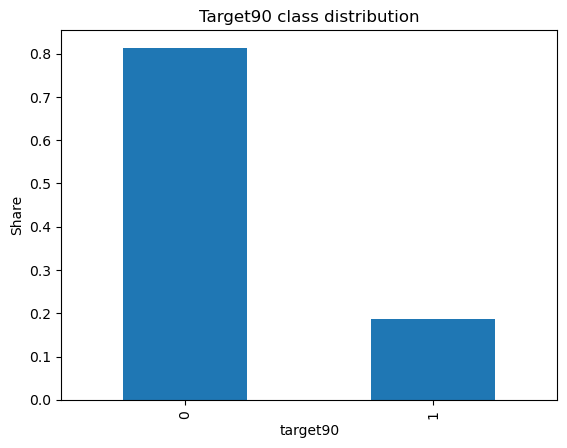

In [12]:
train["target90"].value_counts(normalize=True).plot(
    kind="bar",
    title="Target90 class distribution"
)
plt.ylabel("Share")
plt.show()


### 2.2 Account tenure and reorder behavior

Customer tenure is expected to proxy loyalty and experience.

<Figure size 640x480 with 0 Axes>

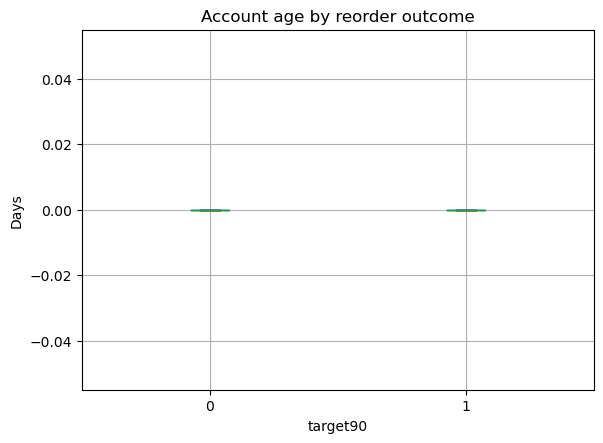

In [13]:
account_age_raw = (
    pd.to_datetime(train["date"], errors="coerce")
    - pd.to_datetime(train["datecreated"], errors="coerce")
).dt.days

plt.figure()
pd.DataFrame({
    "account_age_days": account_age_raw,
    "target90": train["target90"]
}).boxplot(
    column="account_age_days",
    by="target90",
    showfliers=False
)
plt.title("Account age by reorder outcome")
plt.suptitle("")
plt.ylabel("Days")
plt.show()


### 2.3 Order size and shipment weight

These variables are highly skewed and may influence reorder probability.


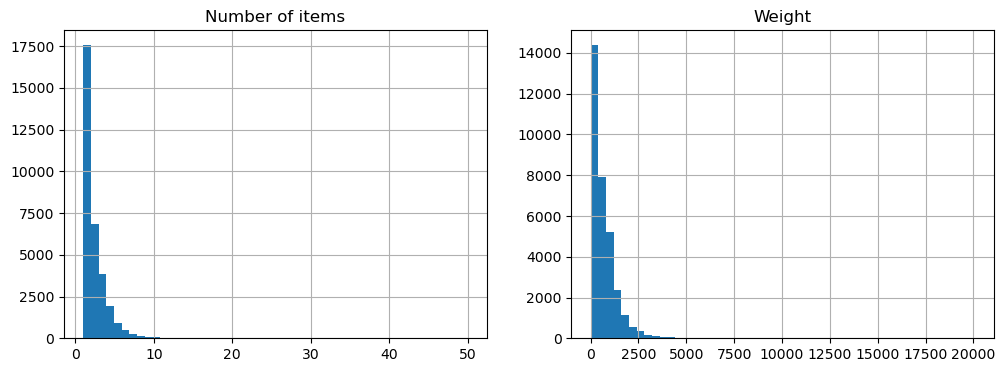

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

train["numberitems"].hist(bins=50, ax=axes[0])
axes[0].set_title("Number of items")

train["weight"].hist(bins=50, ax=axes[1])
axes[1].set_title("Weight")

plt.show()


### 2.4 Product-category purchase patterns

Most category counts are sparse with long tails.



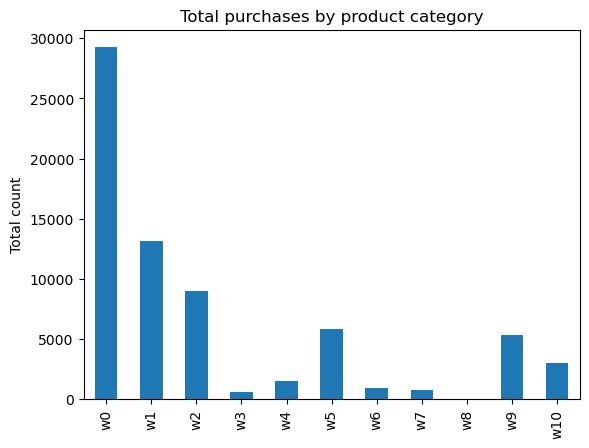

In [15]:
w_cols = [f"w{i}" for i in range(11)]

train[w_cols].sum().plot(
    kind="bar",
    title="Total purchases by product category"
)
plt.ylabel("Total count")
plt.show()



### 2.5 Promised delivery timing

Delivery expectations may influence customer satisfaction and repeat purchases.


<Figure size 640x480 with 0 Axes>

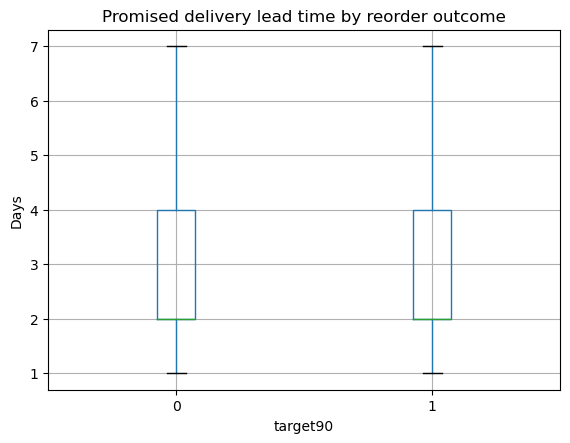

In [16]:
promised_lead_time_raw = (
    pd.to_datetime(train["deliverydatepromised"], errors="coerce")
    - pd.to_datetime(train["date"], errors="coerce")
).dt.days

plt.figure()
pd.DataFrame({
    "promised_lead_time": promised_lead_time_raw,
    "target90": train["target90"]
}).boxplot(
    column="promised_lead_time",
    by="target90",
    showfliers=False
)
plt.title("Promised delivery lead time by reorder outcome")
plt.suptitle("")
plt.ylabel("Days")
plt.show()


### 2.6 Incentives and service indicators

We inspect whether basic service and incentive variables differ by reorder behavior.


In [17]:
cat_vars = [
    "salutation", "title", "domain", "newsletter", "model",
    "paymenttype", "deliverytype", "voucher", "gift",
    "entry", "shippingcosts", "case"
]

for c in cat_vars:
    print(c, train[c].nunique())


salutation 3
title 2
domain 13
newsletter 2
model 3
paymenttype 4
deliverytype 2
voucher 2
gift 2
entry 2
shippingcosts 2
case 5


## 3. Data transformations and feature engineering

We construct a leakage-safe baseline feature set and clearly separate optional transformations for later robustness checks.


### 3.1 Feature removal (baseline)

We remove identifiers, constant variables, and features with extreme missingness or leakage risk.


In [18]:
# Copy to avoid modifying raw inspection data
data_fe = train.copy()

# Drop identifier
data_fe.drop(columns=["customernumber"], inplace=True)

# Drop constant feature
data_fe.drop(columns=["points"], inplace=True)

# Drop unusable postcode
data_fe.drop(columns=["delivpostcode"], inplace=True)




### 3.2 Advertising exposure indicator

We retain only the presence of advertising information, not the raw code.


In [19]:
data_fe["has_ad_code"] = data_fe["advertisingdatacode"].notna().astype(int)
data_fe.drop(columns=["advertisingdatacode"], inplace=True)


We believe missingness here can be informative. Raw advertising codes are high-cardnality and sparse

### 3.3 Date parsing

We convert date columns to datetime to enable duration and calendar features.


In [20]:
date_cols = ["date", "datecreated", "deliverydatepromised","deliverydatereal" ]

for c in date_cols:
    data_fe[c] = pd.to_datetime(data_fe[c], errors="coerce")


### 3.4 Time-based features

We extract interpretable duration and calendar features known at order time.


In [21]:
# Customer tenure
data_fe["account_age_days"] = (data_fe["date"] - data_fe["datecreated"]).dt.days

# Order timing
data_fe["order_weekday"] = data_fe["date"].dt.weekday
data_fe["order_month"] = data_fe["date"].dt.month

# Promised delivery timing
data_fe["promised_delivery_weekday"] = data_fe["deliverydatepromised"].dt.weekday
data_fe["promised_delivery_month"] = data_fe["deliverydatepromised"].dt.month

# Promised lead time
data_fe["delivery_difference"] = (
    data_fe["deliverydatereal"] - data_fe["deliverydatepromised"]
).dt.days


### 3.5 Drop raw date variables

After feature extraction, raw datetime columns are no longer needed.


In [22]:
data_fe.drop(columns=["date", "datecreated", "deliverydatepromised","deliverydatereal"], inplace=True)


### 3.6 Product-category aggregation

We summarize sparse product-category counts into a single diversity measure.


In [23]:
w_cols = [f"w{i}" for i in range(11)]
data_fe["product_diversity"] = (data_fe[w_cols] > 0).sum(axis=1)


this reduces dimensionality and preserves signal on breath of engagement

In [24]:
data_fe.isna().sum().sort_values(ascending=False)

delivery_difference          5478
promised_delivery_month         9
promised_delivery_weekday       9
salutation                      0
w9                              0
w3                              0
w4                              0
w5                              0
w6                              0
w7                              0
w8                              0
target90                        0
w10                             0
title                           0
has_ad_code                     0
account_age_days                0
order_weekday                   0
order_month                     0
w2                              0
w1                              0
w0                              0
used                            0
domain                          0
newsletter                      0
model                           0
paymenttype                     0
deliverytype                    0
invoicepostcode                 0
voucher                         0
case          

## 3.7 Outsert the missings 

In [25]:
delay_median = data_fe["delivery_difference"].median()
data_fe["delivery_difference"].fillna(delay_median, inplace=True)

C:\Users\Franzi\AppData\Local\Temp\ipykernel_14032\1733387124.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_fe["delivery_difference"].fillna(delay_median, inplace=True)


In [26]:
# we just need the mode for the other variables because the 9 observations are purely negligable
for col in ["promised_delivery_month",
            "promised_delivery_weekday"]:
    data_fe[col].fillna(data_fe[col].mode()[0], inplace=True)

C:\Users\Franzi\AppData\Local\Temp\ipykernel_14032\1188255644.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_fe[col].fillna(data_fe[col].mode()[0], inplace=True)


## 3.8 Check all data types

In [27]:
data_types = pd.DataFrame({
    "column": data_fe.columns,
    "dtype" : data_fe.dtypes.values
})
data_types

,column,dtype
0,salutation,int64
1,title,int64
2,domain,int64
3,newsletter,int64
4,model,int64
5,paymenttype,int64
6,deliverytype,int64
7,invoicepostcode,int64
8,voucher,int64
9,case,int64


In [28]:
# save features as categorical
data_fe['salutation'] = data_fe['salutation'].astype('category')
data_fe['paymenttype'] = data_fe['paymenttype'].astype('category')
data_fe['deliverytype'] = data_fe['deliverytype'].astype('category')
data_fe['entry'] = data_fe['entry'].astype('category')

# handling ordinal data
data_fe['case'].unique()
cases=1,2,3,4,5
data_fe['case'] = data_fe['case'].astype('category')
data_fe['case'] = data_fe['case'].cat.set_categories(cases, ordered=True)
data_fe['case'].unique()

[2, 1, 3, 4, 5]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

## 3.9 Feature creation 

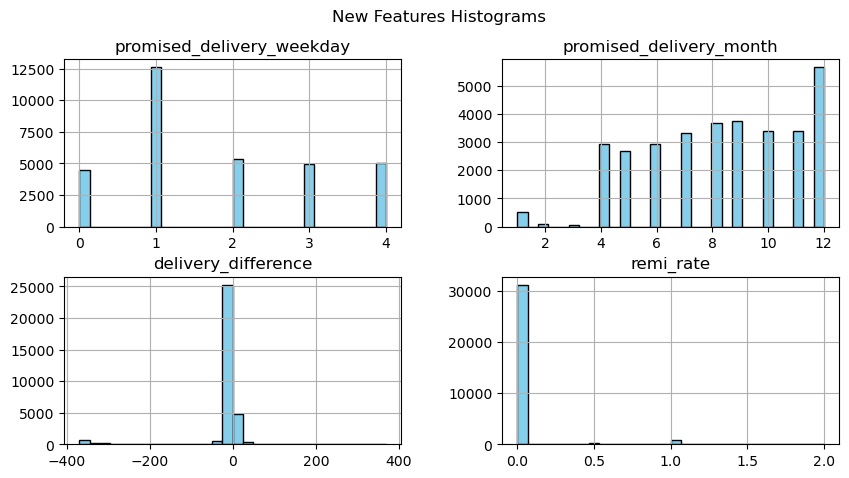

In [29]:
data_fe['remi_rate']=data_fe['remi']/data_fe['numberitems']


# Analyze the new features
new_features = data_fe.select_dtypes(include=['float64']).columns

# Plot histograms for the new features
data_fe[new_features].hist(bins=30, figsize=(10, 5), color='skyblue', edgecolor='black')
plt.suptitle('New Features Histograms', fontsize=12)
plt.show()

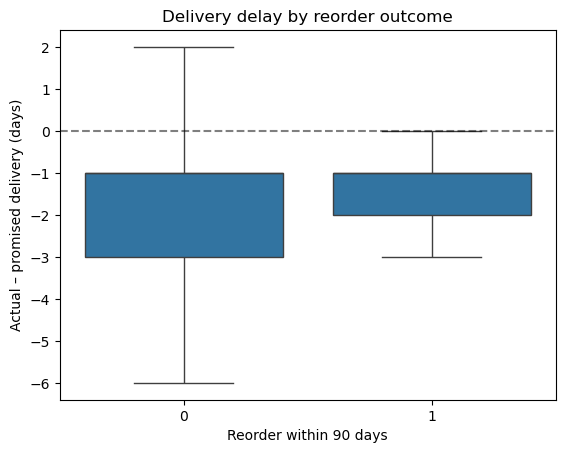

In [30]:
import seaborn as sns 

sns.boxplot(
    data=data_fe,
    x="target90",
    y="delivery_difference",
    showfliers=False
)
plt.axhline(0, color="black", linestyle="--", alpha=0.5)
plt.title("Delivery delay by reorder outcome")
plt.ylabel("Actual – promised delivery (days)")
plt.xlabel("Reorder within 90 days")
plt.show()


<Axes: xlabel='has_return', ylabel='target90'>

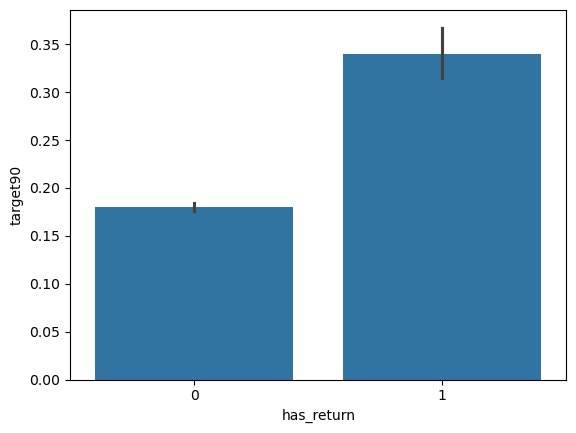

In [31]:
# Create a temporary dataframe for analysis only
df_return_analysis = data_fe.assign(
    has_return=(data_fe["remi_rate"] > 0).astype(int)
)

# Compute reorder probability by return behavior
df_return_analysis.groupby("has_return")["target90"].mean()

# Compute reorder probability and group sizes
df_return_analysis.groupby("has_return")["target90"].agg(
    reorder_rate="mean",
    count="count"
)

sns.barplot(
    data=df_return_analysis,
    x="has_return",
    y="target90"
)


<function matplotlib.pyplot.show(close=None, block=None)>

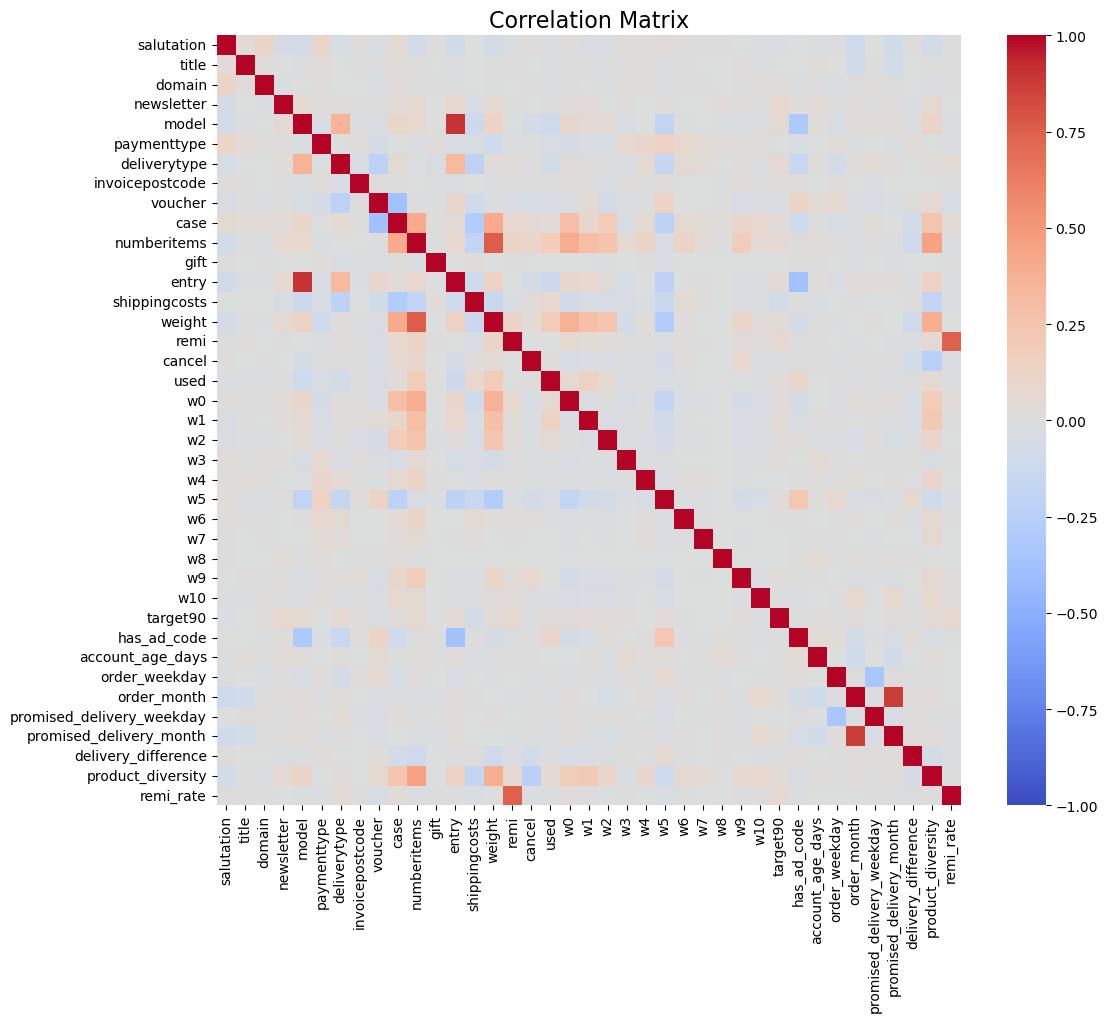

In [32]:
# Correlation matrix 
corr_matrix = data_fe.corr()
corr_matrix

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar=True)
plt.title("Correlation Matrix", fontsize=16)
plt.show

## 3. Data transformations and feature engineering (implemented)

This section documents the feature engineering steps applied to the raw training data prior to building the preprocessing pipeline.

### 3.1 Column removals (data cleaning)
- **Dropped `customernumber`**: identifier only; not meaningful as a predictive feature.
- **Dropped `points`**: constant (zero variance), therefore no predictive value.
- **Dropped `delivpostcode`**: ~95% missingness; too sparse to be informative without heavy imputation.

### 3.2 Advertising information (missingness signal)
- **Created `has_ad_code` = 1 if `advertisingdatacode` is present else 0**, then dropped `advertisingdatacode`.
  - Rationale: the *presence* of tracking information can carry behavioral/marketing signal, while the raw code is high-cardinality and mostly missing.

### 3.3 Datetime conversion (enables time-based features)
Converted the following columns to datetime using `errors="coerce"`:
- `date`, `datecreated`, `deliverydatepromised`, `deliverydatereal`
  - Rationale: ensures consistent parsing and gracefully handles invalid date entries by converting them to `NaT`.

### 3.4 Time-derived customer and order features
Engineered the following features from `date` and `datecreated`:
- **`account_age_days` = `date` − `datecreated`**  
  - Rationale: proxies tenure/relationship maturity, often correlated with retention.
- **`order_weekday`** (0–6) and **`order_month`** (1–12) from `date`  
  - Rationale: captures seasonality and weekday behavioral patterns.

### 3.5 Delivery timing feature
Engineered:
- **`delivery_difference` = `deliverydatereal` − `deliverydatepromised` (days)**  
  - Rationale: delivery experience may affect customer satisfaction and reorder propensity.

After feature extraction, dropped raw datetime columns:
- `date`, `datecreated`, `deliverydatepromised`, `deliverydatereal`
  - Rationale: avoids redundancy and prevents downstream models from using raw timestamps directly.

### 3.6 Product-category aggregation
Created:
- **`product_diversity` = number of product-category counts `w0..w10` that are > 0**
  - Rationale: compresses sparse category information into an interpretable breadth-of-purchase metric while reducing dimensionality.

### 3.7 Missing value handling (post-engineering)
Observed missingness after engineering:
- `delivery_difference`: 5,478 missing (from invalid/missing coerced datetimes)
- `promised_delivery_month`: 9 missing
- `promised_delivery_weekday`: 9 missing

Imputation applied:
- **`delivery_difference` filled with median**
  - Rationale: median is robust to heavy tails and outliers in delay distributions.
- **`promised_delivery_month` and `promised_delivery_weekday` filled with mode**
  - Rationale: very few missing values; mode maintains the most common calendar pattern without distorting scale.

### 3.8 Resulting feature set (current schema)
After transformations, the dataset contains:
- Original integer-coded categorical features: `salutation`, `title`, `domain`, `newsletter`, `model`, `paymenttype`, `deliverytype`, `invoicepostcode`, `voucher`, `case`, `gift`, `entry`, `shippingcosts`
- Numeric/count features: `numberitems`, `weight`, `remi`, `cancel`, `used`, `w0..w10`
- Engineered features: `has_ad_code`, `account_age_days`, `order_weekday`, `order_month`, `promised_delivery_weekday`, `promised_delivery_month`, `delivery_difference`, `product_diversity`
- Target: `target90`

In [33]:
# Importnat those categorical variables that I created and should be preserved
for c in ["promised_delivery_weekday", "promised_delivery_month"]:
    data_fe[c] = data_fe[c].astype(int)

data_fe.drop(columns=["invoicepostcode"], inplace=True)

# 4. Data splitting and one-hot encoding

In [34]:
from sklearn.model_selection import train_test_split

X = data_fe.drop(columns=["target90"])
y = data_fe["target90"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


## 4.1 One hot encoding

In [35]:
w_cols = [f"w{i}" for i in range(11)]

cat_cols = [
    "salutation","title","domain","newsletter","model",
    "paymenttype","deliverytype","voucher","gift","entry",
    "shippingcosts"
   
]

num_cols = [
    "case",  # keep ordinal in baseline
    "numberitems","weight","remi","cancel","used",
    "has_ad_code","account_age_days","order_weekday","order_month",
    "promised_delivery_weekday","promised_delivery_month",
    "delivery_difference","product_diversity", 
    *w_cols
]


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols),
    ],
    remainder="drop"
)


### 4.2 Preprocessing sanity checks

We confirm that preprocessing produces consistent feature matrices for train and validation.


In [37]:
X_train_t = preprocess.fit_transform(X_train)
X_val_t = preprocess.transform(X_val)

X_train_t.shape, X_val_t.shape


((24321, 62), (8107, 62))

In [38]:
# Numeric names are unchanged
num_names = num_cols

# One-hot names for categoricals
ohe = preprocess.named_transformers_["cat"].named_steps["ohe"]
cat_names = ohe.get_feature_names_out(cat_cols).tolist()

feature_names = num_names + cat_names
len(feature_names), X_train_t.shape[1]


(62, 62)

In [39]:
# create the final datasets
X_train_df = pd.DataFrame(
    X_train_t,
    columns=feature_names,
    index=X_train.index
)

X_val_df = pd.DataFrame(
    X_val_t,
    columns=feature_names,
    index=X_val.index
)


In [40]:
X_train_df.shape, X_val_df.shape


((24321, 62), (8107, 62))

In [41]:
X_train_df.isna().sum().sum(), X_val_df.isna().sum().sum()
# did any kind of missings snuck in ?


(0, 0)

## 5. Applying transformations to the test set

We apply the exact same feature engineering and fitted preprocessing steps to the test data to ensure consistency.


In [42]:
test = pd.read_csv("test.csv", sep=";")

C:\Users\Franzi\AppData\Local\Temp\ipykernel_14032\3657819784.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv("test.csv", sep=";")


drop remi, used und cancel?

In [43]:
import pandas as pd
import numpy as np

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the project's feature engineering steps to a raw dataframe.
    This function does NOT mutate the input.
    """
    out = df.copy()

    # Drop columns we decided not to use
    out.drop(columns=["customernumber", "points", "delivpostcode"], inplace=True, errors="ignore")

    # Advertising indicator (presence only)
    if "advertisingdatacode" in out.columns:
        out["has_ad_code"] = out["advertisingdatacode"].notna().astype(int)
        out.drop(columns=["advertisingdatacode"], inplace=True)

    # Parse datetime columns
    for c in ["date", "datecreated", "deliverydatepromised", "deliverydatereal"]:
        if c in out.columns:
            out[c] = pd.to_datetime(out[c], errors="coerce")

    # Engineered time features
    out["account_age_days"] = (out["date"] - out["datecreated"]).dt.days
    out["order_weekday"] = out["date"].dt.weekday
    out["order_month"] = out["date"].dt.month

    out["promised_delivery_weekday"] = out["deliverydatepromised"].dt.weekday
    out["promised_delivery_month"] = out["deliverydatepromised"].dt.month

    # Delivery difference (OPTION: potentially leaky)
    out["delivery_difference"] = (out["deliverydatereal"] - out["deliverydatepromised"]).dt.days

    # Drop raw datetime columns
    out.drop(
        columns=["date", "datecreated", "deliverydatepromised", "deliverydatereal"],
        inplace=True,
        errors="ignore"
    )

    # Product diversity
    w_cols = [f"w{i}" for i in range(11)]
    existing_w = [c for c in w_cols if c in out.columns]
    out["product_diversity"] = (out[existing_w] > 0).sum(axis=1)

    # Your latest choice: drop invoicepostcode to keep features <= ~65
    out.drop(columns=["invoicepostcode"], inplace=True, errors="ignore")

    # Ensure discrete engineered features are integers where possible (NaNs handled later by imputers)
    # We'll cast after imputation in the pipeline, but keeping them numeric is fine here.

    return out


In [44]:
test_fe = engineer_features(test)

In [45]:
X_test_t = preprocess.transform(test_fe)

In [46]:
X_test_df = pd.DataFrame(
    X_test_t,
    columns=feature_names,
    index=test_fe.index
)


In [47]:
missing = [c for c in (num_cols + cat_cols) if c not in test_fe.columns]
extra = [c for c in test_fe.columns if c not in (num_cols + cat_cols)]
missing, extra[:20]


([], [])

In [48]:
X_test_t.shape

(32427, 62)

# ML Modeling Pipeline: Strategic Voucher Targeting

Here we implement an end-to-end modeling workflow for maximizing expected revenue from sending €5 vouchers to customers after their first purchase.

**Business Objective**: Optimize the decision to send vouchers to maximize net revenue.

**Key Decision Rule**: Send voucher when predicted probability of reorder (target90=1) is **below** a threshold, i.e., send to customers predicted as **not reordering**.


## 1. Imports and Config

We import the required libraries for data handling, visualization, model training, and evaluation. We also set a fixed random seed to ensure reproducible results and use availability checks for optional packages (Optuna, XGBoost) so the notebook remains executable even if they are not installed.

In [49]:
# CELL 1 — Imports + setup (same as yours)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    HistGradientBoostingClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)


import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports completed successfully.")



Imports completed successfully.


## Checking train and test set and making sure everything is coherent before modeling 

In [50]:
try:
    _ = X_train_df.shape
    _ = X_val_df.shape
    _ = X_test_df.shape
    _ = y_train.shape
    _ = y_val.shape
    print("Using preprocessed data from memory.")
except NameError as e:
    raise NameError(
        "X_train_df / X_val_df / X_test_df / y_train / y_val not found. "
        "Run preprocessing/feature engineering first."
    ) from e

# Quality checks
assert X_train_df.columns.equals(X_val_df.columns), "Train and validation columns don't match"
assert X_val_df.columns.equals(X_test_df.columns), "Validation and test columns don't match"
assert X_train_df.isna().sum().sum() == 0, "NaNs found in X_train_df"
assert X_val_df.isna().sum().sum() == 0, "NaNs found in X_val_df"
assert X_test_df.isna().sum().sum() == 0, "NaNs found in X_test_df"

print(f"Train shape: {X_train_df.shape}")
print(f"Validation shape: {X_val_df.shape}")
print(f"Test shape: {X_test_df.shape}")
print(f"Positive class rate (train): {y_train.mean():.4f}")
print(f"Positive class rate (val): {y_val.mean():.4f}")


Using preprocessed data from memory.
Train shape: (24321, 62)
Validation shape: (8107, 62)
Test shape: (32427, 62)
Positive class rate (train): 0.1866
Positive class rate (val): 0.1866


# Revenue and Treshhold optimization

Here we translate model probabilities into business outcomes 
We define a custom revenue function that maps predicted reorder probabilities to voucher decisions and monetary outcomes. A voucher is sent only when the predicted probability of reordering is sufficiently low. Since sending a voucher has asymmetric gains and losses, we optimize the probability threshold on the validation set to maximize total expected revenue rather than relying on a fixed classification threshold.

In [51]:
# Revenue and Treshhold calculation
def calculate_revenue(y_true, y_pred_proba, threshold):
    """
    Decision rule: send_voucher = 1 if p(reorder=1) < threshold else 0
    
    Revenue:
    - send & y==0 => +1.25
    - send & y==1 => -5
    - else => 0
    """
    y_true = np.asarray(y_true)
    y_pred_proba = np.asarray(y_pred_proba)

    send_voucher = (y_pred_proba < threshold).astype(int)

    revenue = np.zeros(len(y_true))
    revenue[(send_voucher == 1) & (y_true == 0)] = 1.25
    revenue[(send_voucher == 1) & (y_true == 1)] = -5.0

    total_revenue = revenue.sum()
    avg_revenue = total_revenue / len(y_true)

    return total_revenue, avg_revenue, send_voucher


def optimize_threshold(y_true, y_pred_proba, threshold_range=None):
    if threshold_range is None:
        threshold_range = np.linspace(0.01, 0.99, 99)

    rows = []
    for t in threshold_range:
        total_rev, avg_rev, _ = calculate_revenue(y_true, y_pred_proba, t)
        rows.append({"threshold": t, "total_revenue": total_rev, "avg_revenue": avg_rev})

    df = pd.DataFrame(rows)
    best_idx = df["total_revenue"].idxmax()
    return float(df.loc[best_idx, "threshold"]), float(df.loc[best_idx, "total_revenue"]), df


print("Revenue function sanity test:")
test_y = np.array([0, 0, 1, 1])
test_p = np.array([0.1, 0.9, 0.1, 0.9])
t = 0.5
tot, avg, send = calculate_revenue(test_y, test_p, t)
print("send:", send, "total:", tot, "avg:", avg)


Revenue function sanity test:
send: [1 0 1 0] total: -3.75 avg: -0.9375


The negative revenue in the sanity test confirms that sending vouchers based on an arbitrary probability threshold can be unprofitable, especially when vouchers are sent to customers who would have reordered anyway. This motivates optimizing the decision threshold based on expected revenue rather than using a fixed cutoff.


## Evaluation code
We first evaluate models using standard classification metrics at the default decision threshold to ensure comparability with classical machine-learning benchmarks. Revenue optimization is then performed separately using predicted probabilities and a business-specific decision rule.


In [52]:

models = {}
results = []

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Reorder", "Reorder"])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.tight_layout()
    plt.show()


def evaluate_model(model, model_name, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)

    y_pred_default = model.predict(X_val)

    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:, 1]  # P(reorder=1)
    elif hasattr(model, "decision_function"):
        s = model.decision_function(X_val)
        y_proba = 1 / (1 + np.exp(-s))
    else:
        y_proba = y_pred_default.astype(float)

    y_proba = np.clip(y_proba, 0, 1)

    acc = accuracy_score(y_val, y_pred_default)
    prec = precision_score(y_val, y_pred_default, zero_division=0)
    rec = recall_score(y_val, y_pred_default, zero_division=0)
    f1 = f1_score(y_val, y_pred_default, zero_division=0)
    auc = roc_auc_score(y_val, y_proba)

    best_t, best_rev, rev_curve = optimize_threshold(y_val, y_proba)


    y_pred_best_t = (y_proba >= best_t).astype(int)

    send_voucher = (y_proba < best_t).astype(int)

    total_rev, avg_rev, _ = calculate_revenue(y_val, y_proba, best_t)

    return {
        "model_name": model_name,

        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc,
        "report_default": classification_report(
            y_val, y_pred_default,
            target_names=["No Reorder", "Reorder"],
            zero_division=0
        ),
        "y_pred_default": y_pred_default,

        "best_threshold": best_t,
        "total_revenue": total_rev,
        "avg_revenue": avg_rev,
        "send_rate": float(send_voucher.mean()),
        "y_pred_best_t": y_pred_best_t,
        "send_voucher": send_voucher,

        "y_proba": y_proba,
        "rev_curve": rev_curve,
    }, model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_action_cm(y_true, send_voucher, title):
    """
    Action confusion matrix:
    rows = true label (0=No Reorder, 1=Reorder)
    cols = action (0=No Send, 1=Send)
    """
    cm = confusion_matrix(y_true, send_voucher, labels=[0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=["No Send", "Send"])
    disp.plot(values_format="d")
    plt.title(title)
    plt.xlabel("Action")
    plt.ylabel("True label (0=No Reorder, 1=Reorder)")
    plt.tight_layout()
    plt.show()



# 5. Models that are being used
## 5.1 Baseline Model
We evaluate simple, non-model-based voucher strategies (always send, never send, random send) to establish economic reference points. These baselines allow us to verify that any machine-learning model provides value beyond trivial or risk-free policies.


In [53]:
def baseline_always_send(y_true):
    y_true = np.asarray(y_true)
    n0 = (y_true == 0).sum()
    n1 = (y_true == 1).sum()
    total = n0 * 1.25 + n1 * (-5.0)
    return total, total / len(y_true)

def baseline_never_send(y_true):
    return 0.0, 0.0

def baseline_random(y_true, p_send=0.5, random_state=RANDOM_STATE):
    rng = np.random.default_rng(random_state)
    y_true = np.asarray(y_true)
    send = rng.binomial(1, p_send, size=len(y_true))
    rev = np.zeros(len(y_true))
    rev[(send == 1) & (y_true == 0)] = 1.25
    rev[(send == 1) & (y_true == 1)] = -5.0
    total = rev.sum()
    return total, total / len(y_true)

def baseline_random_mean(y_true, p_send=0.5, n_runs=1000):
    totals = []
    for i in range(n_runs):
        total, _ = baseline_random(y_true, p_send, random_state=i)
        totals.append(total)
    total = np.mean(totals)
    return total, total / len(y_true)

print("Baselines on validation:")
for name, fn in [
    ("Always Send", baseline_always_send),
    ("Never Send", baseline_never_send),
]:
    total, avg = fn(y_val)
    print(f"{name:12s}  total=€{total:8.2f}   avg=€{avg:6.4f}")

total, avg = baseline_random_mean(y_val, p_send=0.5)
print(f"{'Random 50%':12s}  total=€{total:8.2f}   avg=€{avg:6.4f}")


Baselines on validation:
Always Send   total=€  677.50   avg=€0.0836
Never Send    total=€    0.00   avg=€0.0000
Random 50%    total=€  342.00   avg=€0.0422


- Always Send makes money, but at high risk and low efficiency.

- Never Send is safe but leaves money on the table.

- Random is worse than Always Send, but still positive due to class imbalance.

- Any ML model must outperform €677.50 on validation to be considered useful.

,policy,total_revenue,avg_revenue
0,Always Send,677.50000,0.083570
1,Never Send,0.00000,0.000000
2,Random 50%,342.00125,0.042186


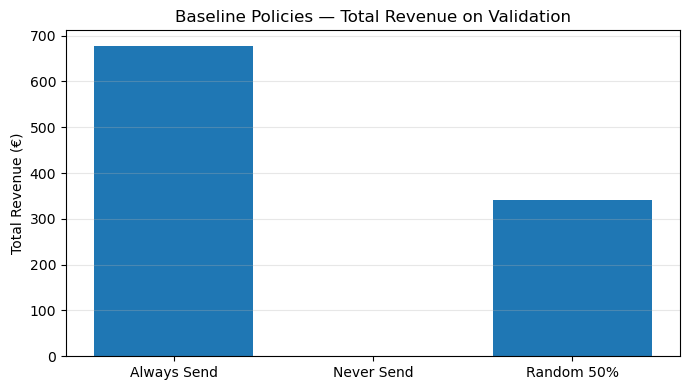

In [54]:
baseline_rows = []
for name, fn in [
    ("Always Send", baseline_always_send),
    ("Never Send", baseline_never_send),
]:
    total, avg = fn(y_val)
    baseline_rows.append({"policy": name, "total_revenue": total, "avg_revenue": avg})

total, avg = baseline_random_mean(y_val, p_send=0.5)
baseline_rows.append({"policy": "Random 50%", "total_revenue": total, "avg_revenue": avg})

baseline_df = pd.DataFrame(baseline_rows)
display(baseline_df)

plt.figure(figsize=(7,4))
plt.bar(baseline_df["policy"], baseline_df["total_revenue"])
plt.title("Baseline Policies — Total Revenue on Validation")
plt.ylabel("Total Revenue (€)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


# 5.Models 

## 5.1 Logistic Regression 


Training & Evaluating: Logistic Regression
ROC-AUC (prob ranking): 0.6197
Best threshold (revenue): 0.5100
Send-rate @ best t: 0.617
Total revenue @ best t: €1668.75
Avg revenue @ best t: €0.2058

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.85      0.65      0.74      6594
     Reorder       0.25      0.51      0.34      1513

    accuracy                           0.62      8107
   macro avg       0.55      0.58      0.54      8107
weighted avg       0.74      0.62      0.66      8107



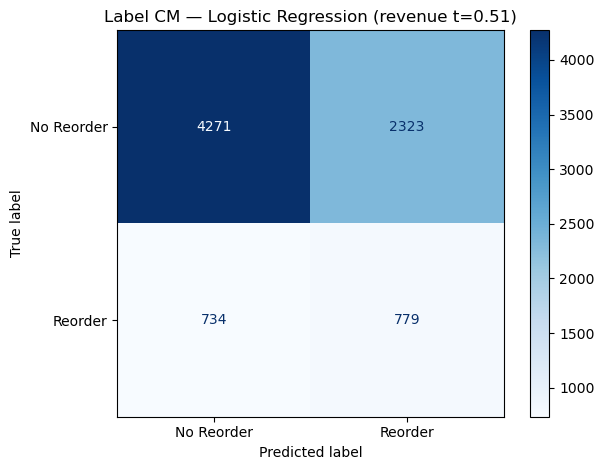

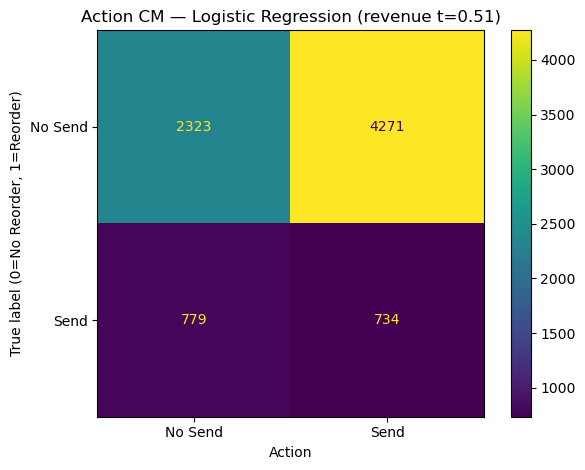

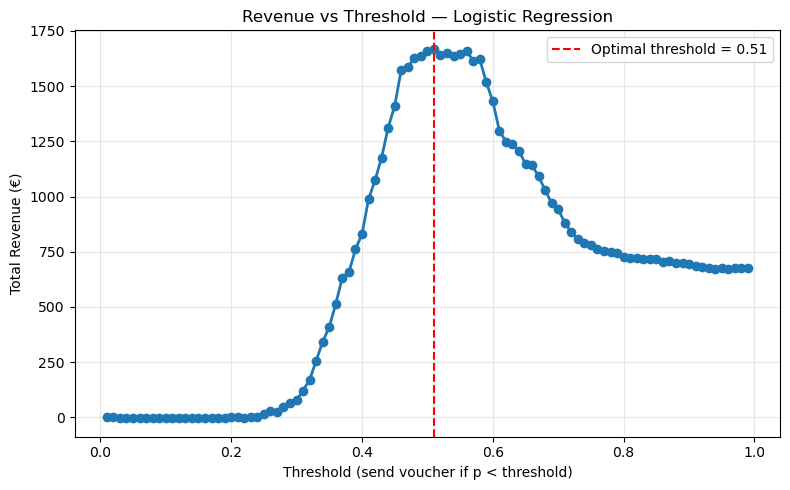

In [55]:
print("\n" + "="*80)
print("Training & Evaluating: Logistic Regression")
print("="*80)

lr = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=5000,
    class_weight="balanced",
    solver="liblinear"
)

res_lr, mdl_lr = evaluate_model(lr, "Logistic Regression", X_train_df, y_train, X_val_df, y_val)
models["Logistic Regression"] = mdl_lr
results.append(res_lr)

print(f"ROC-AUC (prob ranking): {res_lr['roc_auc']:.4f}")
print(f"Best threshold (revenue): {res_lr['best_threshold']:.4f}")
print(f"Send-rate @ best t: {res_lr['send_rate']:.3f}")
print(f"Total revenue @ best t: €{res_lr['total_revenue']:.2f}")
print(f"Avg revenue @ best t: €{res_lr['avg_revenue']:.4f}")

print("\nClassification report at revenue-optimal threshold:")
print(classification_report(
    y_val,
    res_lr["y_pred_best_t"],
    target_names=["No Reorder", "Reorder"],
    zero_division=0
))

plot_cm(
    y_val,
    res_lr["y_pred_best_t"],
    f"Label CM — Logistic Regression (revenue t={res_lr['best_threshold']:.2f})"
)

plot_action_cm(
    y_val,
    res_lr["send_voucher"],   # use returned key
    f"Action CM — Logistic Regression (revenue t={res_lr['best_threshold']:.2f})"
)

plt.figure(figsize=(8, 5))
plt.plot(res_lr["rev_curve"]["threshold"], res_lr["rev_curve"]["total_revenue"], marker="o", linewidth=2)
plt.axvline(res_lr["best_threshold"], color="red", linestyle="--",
            label=f"Optimal threshold = {res_lr['best_threshold']:.2f}")
plt.title("Revenue vs Threshold — Logistic Regression")
plt.xlabel("Threshold (send voucher if p < threshold)")
plt.ylabel("Total Revenue (€)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()



### Interpretation of the confuison matrix for the logistic regression

0 = No reorder, 1 = reorder

**Interpretation of the action based CF**:

- 4,271 customers would not reorder and are correctly sent a voucher (profitable cases)
- 734 customers would reorder but are nevertheless sent a voucher (costly mistakes)
- 779 customers would reorder and are correctly not sent a voucher
- 2,323 customers would not reorder and are not detected by the model (missed opportunities)

Support: Shows us how many true examples of the class exist, both together should yield the test set 

Accuracy: shows that out of all predictions how many were correct (62%)

Precision: when the model predicts a reorder, it is correct only 25% of the time, while predictions of no reorder are correct 85% of the time.

Recall (Sensitivity): the model identifies 51% of true reorderers and 65% of true non-reorderers.
These metrics confirm that logistic regression has limited predictive power for reorderers, which explains its lower revenue compared to tree-based models.



# 5.2 Random Forest 


Training & Evaluating: Random Forest
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.86      0.68      0.76      6594
     Reorder       0.27      0.51      0.35      1513

    accuracy                           0.65      8107
   macro avg       0.56      0.60      0.56      8107
weighted avg       0.75      0.65      0.69      8107

Default metrics -> Acc: 0.6522 | Prec(1): 0.2708 | Rec(1): 0.5102 | F1(1): 0.3538 | ROC-AUC: 0.6395

Revenue-optimized decision:
Best threshold (revenue): 0.4900
Send-rate @ best t: 0.610
Total Revenue @ best t: €1996.25
Average Revenue @ best t: €0.2462


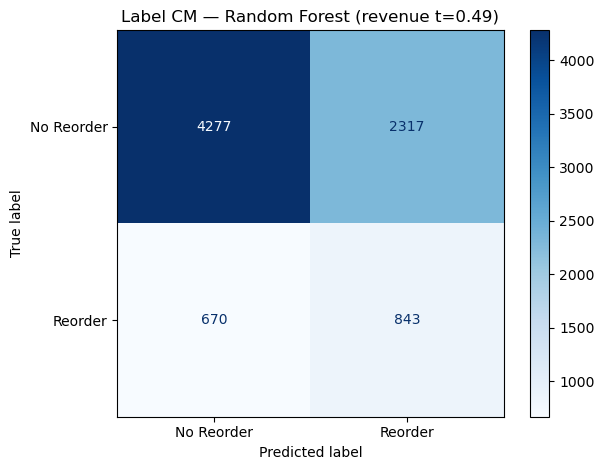

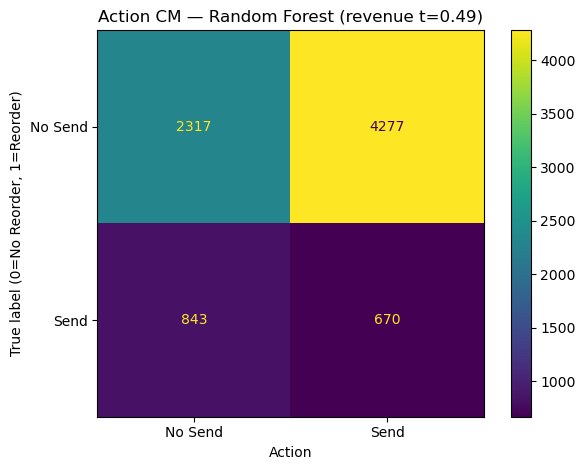

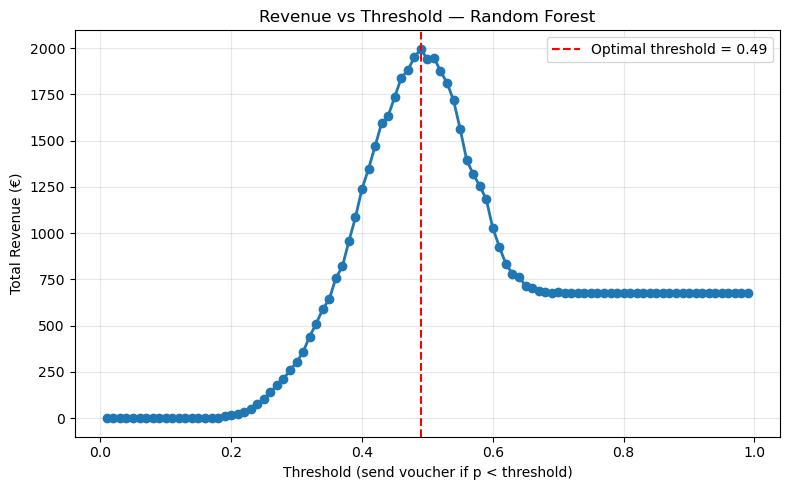

In [56]:
print("\n" + "="*80)
print("Training & Evaluating: Random Forest")
print("="*80)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

result_rf, model_rf = evaluate_model(rf, "Random Forest", X_train_df, y_train, X_val_df, y_val)
models["Random Forest"] = model_rf
results.append(result_rf)

print("Default-threshold classification report:")
print(result_rf["report_default"])
print(
    f"Default metrics -> Acc: {result_rf['accuracy']:.4f} | "
    f"Prec(1): {result_rf['precision']:.4f} | Rec(1): {result_rf['recall']:.4f} | "
    f"F1(1): {result_rf['f1']:.4f} | ROC-AUC: {result_rf['roc_auc']:.4f}"
)

print("\nRevenue-optimized decision:")
print(f"Best threshold (revenue): {result_rf['best_threshold']:.4f}")
print(f"Send-rate @ best t: {result_rf['send_rate']:.3f}")
print(f"Total Revenue @ best t: €{result_rf['total_revenue']:.2f}")
print(f"Average Revenue @ best t: €{result_rf['avg_revenue']:.4f}")

plot_cm(
    y_val,
    result_rf["y_pred_best_t"],
    f"Label CM — Random Forest (revenue t={result_rf['best_threshold']:.2f})"
)

plot_action_cm(
    y_val,
    result_rf["send_voucher"],
    f"Action CM — Random Forest (revenue t={result_rf['best_threshold']:.2f})"
)

plt.figure(figsize=(8, 5))
plt.plot(result_rf["rev_curve"]["threshold"], result_rf["rev_curve"]["total_revenue"], marker="o", linewidth=2)
plt.axvline(result_rf["best_threshold"], color="red", linestyle="--",
            label=f"Optimal threshold = {result_rf['best_threshold']:.2f}")
plt.title("Revenue vs Threshold — Random Forest")
plt.xlabel("Threshold (send voucher if p < threshold)")
plt.ylabel("Total Revenue (€)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Interpretation of the confuison matrix for the random forest

0 = No reorder, 1 = reorder

**Interpretation of the action based CF**:
- 4,277 customers would not reorder and are correctly sent a voucher (profitable cases)
- 670 customers would reorder but are nevertheless sent a voucher (costly mistakes)
- 843 customers would reorder and are correctly not sent a voucher
- 2,317 customers would not reorder and are not detected by the model (missed opportunities)

Support: Shows us how many true examples of the class exist, both together should yield the test set 

Accuracy: shows that out of all predictions we detect 65% correct

Precision: When the model predicts a class how often is it correct
When the model predicts buy again it is correct 27 % and when it predicts no reorder it is correct 86%.

Recall (Sensitivity): Out of all positives how many did we catch
We only correctly flagged  ~51% of the people who actually reorder. We flagged 68% of the people who do not reorder



## 5.3 Gradient Boosting


In [57]:
from sklearn.metrics import classification_report

def print_and_plot_result(res, model_title):
    print("\n" + "="*80)
    print(f"Training & Evaluating: {model_title}")
    print("="*80)

    if "report_default" in res:
        print("Default-threshold classification report:")
        print(res["report_default"])
        print(
            f"Default metrics -> Acc: {res['accuracy']:.4f} | "
            f"Prec(1): {res['precision']:.4f} | Rec(1): {res['recall']:.4f} | "
            f"F1(1): {res['f1']:.4f} | ROC-AUC: {res['roc_auc']:.4f}"
        )
    else:
        print(f"ROC-AUC: {res['roc_auc']:.4f}")

    print("\nRevenue-optimized decision:")
    print(f"Best threshold (revenue): {res['best_threshold']:.4f}")
    print(f"Send-rate @ best t: {res['send_rate']:.3f}")
    print(f"Total Revenue @ best t: €{res['total_revenue']:.2f}")
    print(f"Average Revenue @ best t: €{res['avg_revenue']:.4f}")

    print("\nClassification report at revenue-optimal threshold:")
    print(classification_report(
        y_val, res["y_pred_best_t"],
        target_names=["No Reorder", "Reorder"],
        zero_division=0
    ))

    plot_cm(y_val, res["y_pred_best_t"], f"Label CM — {model_title} (revenue t={res['best_threshold']:.2f})")
    plot_action_cm(y_val, res["send_voucher"], f"Action CM — {model_title} (revenue t={res['best_threshold']:.2f})")

    plt.figure(figsize=(8, 5))
    plt.plot(res["rev_curve"]["threshold"], res["rev_curve"]["total_revenue"], marker="o", linewidth=2)
    plt.axvline(res["best_threshold"], color="red", linestyle="--",
                label=f"Optimal threshold = {res['best_threshold']:.2f}")
    plt.title(f"Revenue vs Threshold — {model_title}")
    plt.xlabel("Threshold (send voucher if p < threshold)")
    plt.ylabel("Total Revenue (€)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()



Training & Evaluating: Gradient Boosting
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.82      1.00      0.90      6594
     Reorder       0.52      0.02      0.03      1513

    accuracy                           0.81      8107
   macro avg       0.67      0.51      0.46      8107
weighted avg       0.76      0.81      0.74      8107

Default metrics -> Acc: 0.8136 | Prec(1): 0.5217 | Rec(1): 0.0159 | F1(1): 0.0308 | ROC-AUC: 0.6418

Revenue-optimized decision:
Best threshold (revenue): 0.2000
Send-rate @ best t: 0.654
Total Revenue @ best t: €2020.00
Average Revenue @ best t: €0.2492

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.86      0.69      0.77      6594
     Reorder       0.28      0.51      0.36      1513

    accuracy                           0.66      8107
   macro avg       0.57      0.60      0.56      8107
weighted a

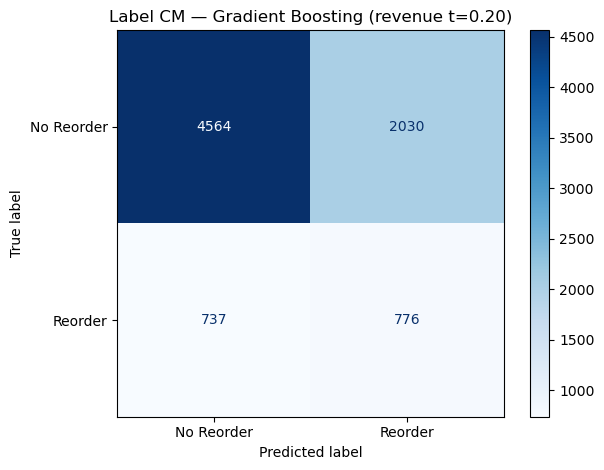

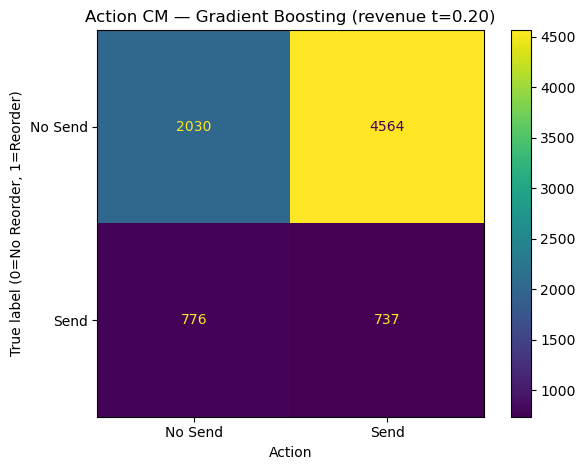

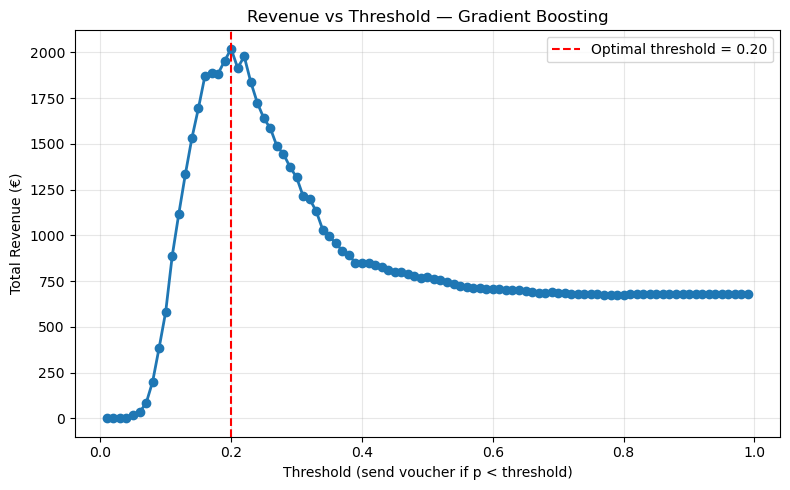

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)

result_gb, model_gb = evaluate_model(gb, "Gradient Boosting", X_train_df, y_train, X_val_df, y_val)
models["Gradient Boosting"] = model_gb
results.append(result_gb)

print_and_plot_result(result_gb, "Gradient Boosting")



### Interpretation of the confuison matrix for the Gradient Boosting

0 = No reorder, 1 = reorder

**Interpretation of the action based CF**:

- 4564 are the correctly identified churners to whom we send a voucher
- 737 are the people that rebuy but we nevertheless send them vouchers
- 776 rebuy and we correctly do not send them vouchers 
- 2030 are churners we do not detect

Support: Shows us how many true examples of the class exist, both together should yield the test set 

Accuracy: Out of all predictions 81% are correctly identified

Precision: When the model predicts a class how often is it correct
When the model predicts buy again it is correct 28 % and when it predicts no reorder it is correct 86%.

Recall (Sensitivity): Out of all positives how many did we catch
We only correctly flagged  ~51% of the people who actually reorder. We flagged 69% of the people who do not reorder



## 5.4 LightGBM

[LightGBM] [Info] Number of positive: 4538, number of negative: 19783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 946
[LightGBM] [Info] Number of data points in the train set: 24321, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.186588 -> initscore=-1.472337
[LightGBM] [Info] Start training from score -1.472337

Training & Evaluating: LightGBM
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.85      0.72      0.78      6594
     Reorder       0.27      0.45      0.34      1513

    accuracy                           0.67      8107
   macro avg       0.56      0.59      0.56      8107
weighted avg       0.74      0.67      0.70      8107

Default metrics -> Acc: 0.6735 | Prec(1): 0

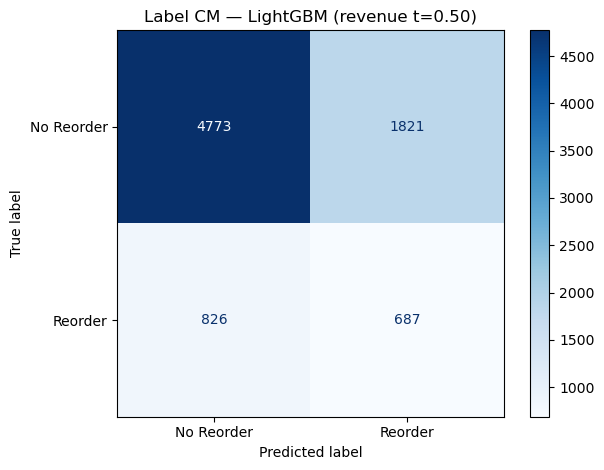

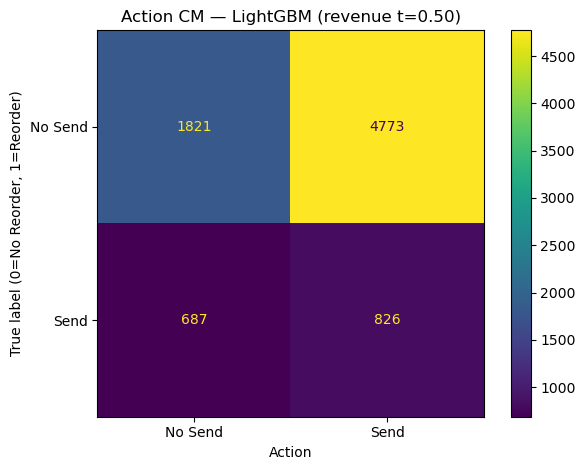

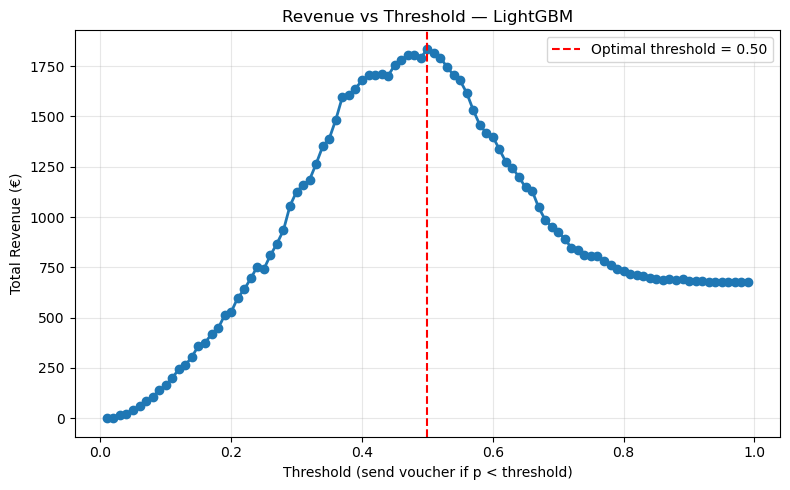

In [59]:
try:
    import lightgbm as lgb
    LGBM_AVAILABLE = True
except ImportError:
    LGBM_AVAILABLE = False

if not LGBM_AVAILABLE:
    print("LightGBM is not installed in this environment. Skipping LightGBM.")
else:
    n_pos = (y_train == 1).sum()
    n_neg = (y_train == 0).sum()
    spw = n_neg / n_pos

    lgbm_clf = lgb.LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.02,
        max_depth=-1,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0,
        class_weight=None,
        scale_pos_weight=spw,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    result_lgbm, model_lgbm = evaluate_model(lgbm_clf, "LightGBM", X_train_df, y_train, X_val_df, y_val)
    models["LightGBM"] = model_lgbm
    results.append(result_lgbm)

    print_and_plot_result(result_lgbm, "LightGBM")


### Interpretation of the confuison matrix for the LightBGM

0 = No reorder, 1 = reorder

**Interpretation of the action based CF**:

- 4773 are the correctly identified churners to whom we send a voucher
- 826 are the people that rebuy but we nevertheless send them vouchers
- 687 rebuy and we correctly do not send them vouchers 
- 1821 are churners we do not detect

Support: Shows us how many true examples of the class exist, both together should yield the test set 

Accuracy: Out of all predictions 67% were predicted correctly

Precision: When the model predicts a class how often is it correct
When the model predicts buy again it is correct 27 % and when it predicts no reorder it is correct 85%.
Of all customers we predicted would reorder, only ~27% actually reordered.

Recall (Sensitivity): Out of all positives how many did we catch
We only correctly flagged  ~45% of the people who actually reorder. We flagged 72% of the people who do not reorder



## 5.5 HistBoost



Training & Evaluating: HistGradientBoosting
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.81      1.00      0.90      6594
     Reorder       0.46      0.00      0.01      1513

    accuracy                           0.81      8107
   macro avg       0.64      0.50      0.45      8107
weighted avg       0.75      0.81      0.73      8107

Default metrics -> Acc: 0.8132 | Prec(1): 0.4615 | Rec(1): 0.0040 | F1(1): 0.0079 | ROC-AUC: 0.6441

Revenue-optimized decision:
Best threshold (revenue): 0.2100
Send-rate @ best t: 0.682
Total Revenue @ best t: €1996.25
Average Revenue @ best t: €0.2462

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.86      0.72      0.78      6594
     Reorder       0.28      0.48      0.36      1513

    accuracy                           0.67      8107
   macro avg       0.57      0.60      0.57      8107
weighte

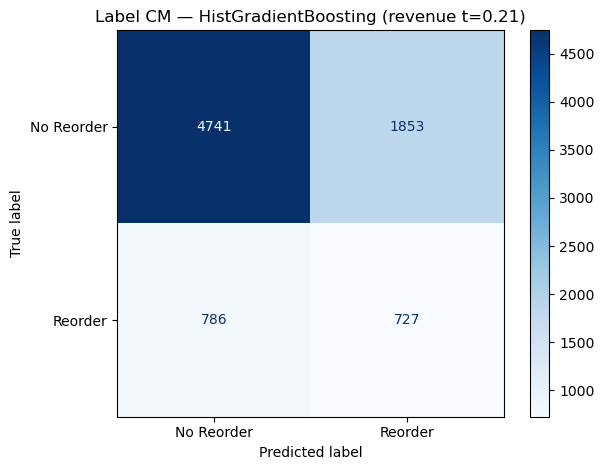

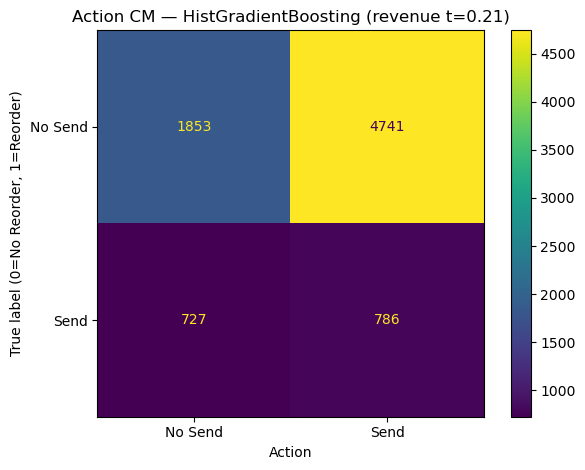

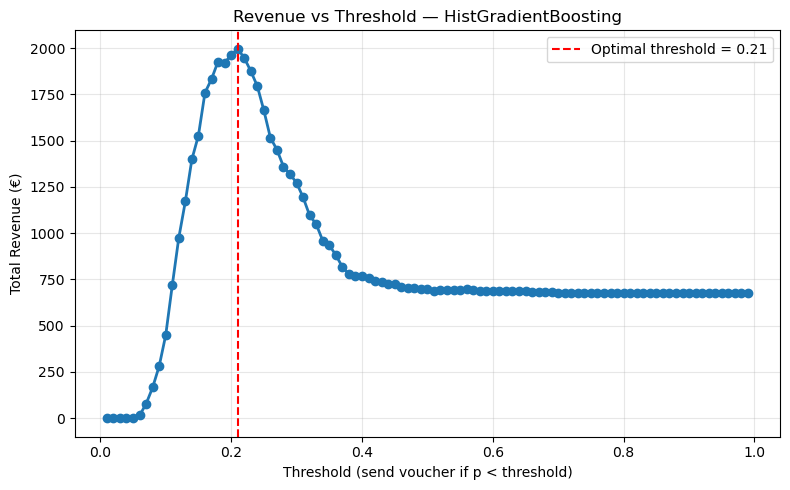

In [60]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgb = HistGradientBoostingClassifier(
    max_depth=6,
    learning_rate=0.05,
    max_iter=400,
    random_state=RANDOM_STATE
)

result_hgb, model_hgb = evaluate_model(hgb, "HistGradientBoosting", X_train_df, y_train, X_val_df, y_val)
models["HistGradientBoosting"] = model_hgb
results.append(result_hgb)

print_and_plot_result(result_hgb, "HistGradientBoosting")


### Interpretation of the confuison matrix for the HistBoost

0 = No reorder, 1 = reorder

**Interpretation of the action based CF**:

- 4741 are the correctly identified churners to whom we send a voucher
- 786 are the people that rebuy but we nevertheless send them vouchers
- 727 rebuy and we correctly do not send them vouchers 
- 1853 are churners we do not detect

Support: Shows us how many true examples of the class exist, both together should yield the test set 

Accuracy: shows that out of all predictions 67% were correct

Precision: When the model predicts a class how often is it correct
When the model predicts buy again it is correct 26 % and when it predicts no reorder it is correct 87%.
Of all customers we predicted would reorder, only ~26% actually reordered.

Recall (Sensitivity): Out of all positives how many did we catch
We only correctly flagged  ~48% of the people who actually reorder. We flagged 72% of the people who do not reorder



## 5.5 K-Nearest Neighbors (with scaling)


Training K-Nearest Neighbors (with StandardScaler)...

Training & Evaluating: KNN
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.82      0.94      0.87      6594
     Reorder       0.26      0.09      0.14      1513

    accuracy                           0.78      8107
   macro avg       0.54      0.52      0.51      8107
weighted avg       0.71      0.78      0.74      8107

Default metrics -> Acc: 0.7807 | Prec(1): 0.2578 | Rec(1): 0.0932 | F1(1): 0.1369 | ROC-AUC: 0.5544

Revenue-optimized decision:
Best threshold (revenue): 0.2800
Send-rate @ best t: 0.757
Total Revenue @ best t: €1083.75
Average Revenue @ best t: €0.1337

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.83      0.77      0.80      6594
     Reorder       0.23      0.30      0.26      1513

    accuracy                           0.68      8107
   macro avg       0.53 

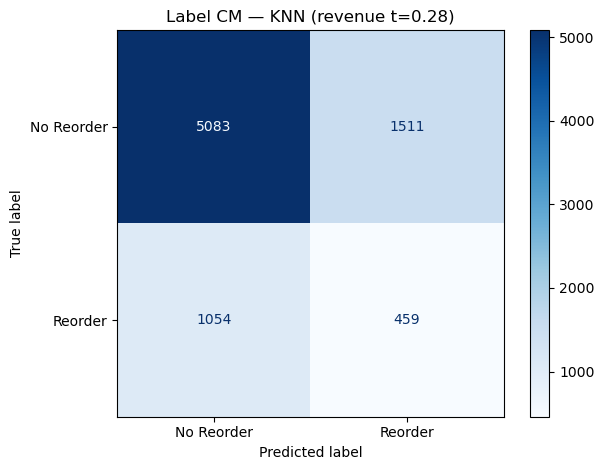

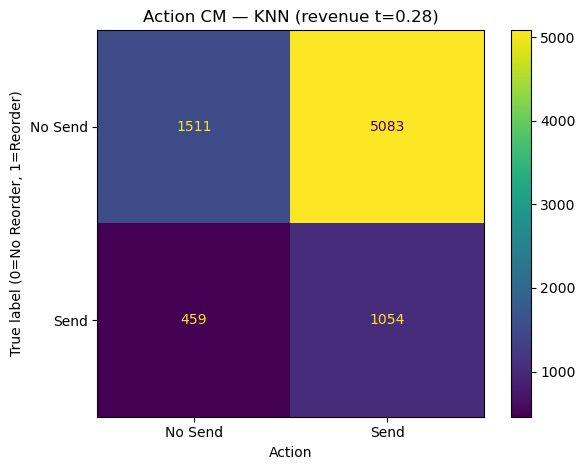

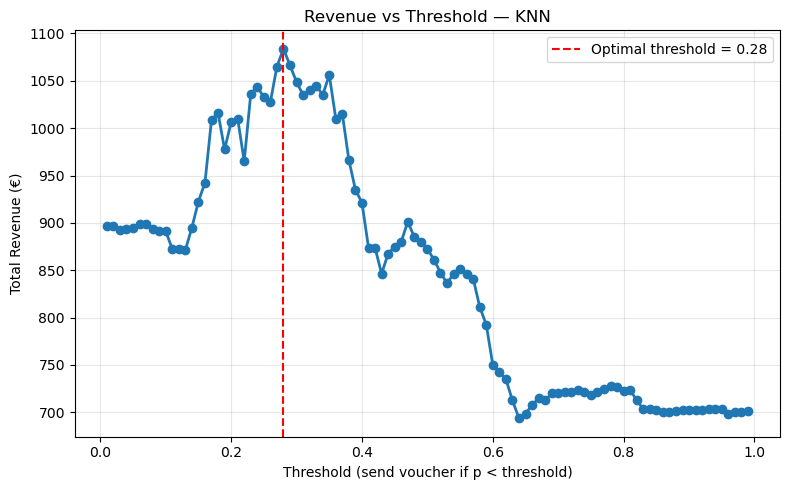

In [61]:
print("Training K-Nearest Neighbors (with StandardScaler)...")

knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5, weights="distance"))
])

result_knn, model_knn = evaluate_model(knn_pipeline, "KNN", X_train_df, y_train, X_val_df, y_val)
models["KNN"] = model_knn
results.append(result_knn)

print_and_plot_result(result_knn, "KNN")




### Interpretation of the confuison matrix for KNN

0 = No reorder, 1 = reorder

**Interpretation of the action based CF**:

- 5083 are the correctly identified churners to whom we send a voucher
- 1054 are the people that rebuy but we nevertheless send them vouchers
- 459 rebuy and we correctly do not send them vouchers 
- 1511 are churners we do not detect

Support: Shows us how many true examples of the class exist, both together should yield the test set 

Accuracy: shows that out of all predictions 78% were predicted correct 

Precision: When the model predicts a class how often is it correct
When the model predicts buy again it is correct 24 % and when it predicts no reorder it is correct 83%.
Of all customers we predicted would reorder, only ~24% actually reordered.

Recall (Sensitivity): Out of all positives how many did we catch
We correctly flagged  70% of the people who actually reorder. We flagged 23% of the people who do not reorder



## 5.6 Now for the Stochastic GB

Training Stochastic GradientBoostingClassifier (subsample<1)...

Training & Evaluating: StochasticGB
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.81      1.00      0.90      6594
     Reorder       0.36      0.01      0.02      1513

    accuracy                           0.81      8107
   macro avg       0.59      0.50      0.46      8107
weighted avg       0.73      0.81      0.73      8107

Default metrics -> Acc: 0.8121 | Prec(1): 0.3611 | Rec(1): 0.0086 | F1(1): 0.0168 | ROC-AUC: 0.6407

Revenue-optimized decision:
Best threshold (revenue): 0.1900
Send-rate @ best t: 0.603
Total Revenue @ best t: €1976.25
Average Revenue @ best t: €0.2438

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.86      0.64      0.74      6594
     Reorder       0.26      0.56      0.36      1513

    accuracy                           0.63      8107
   ma

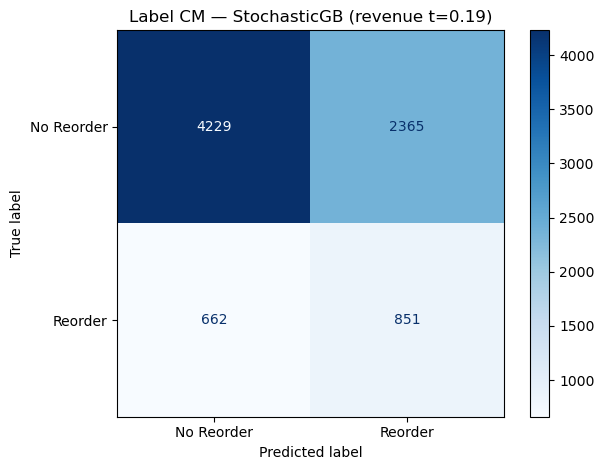

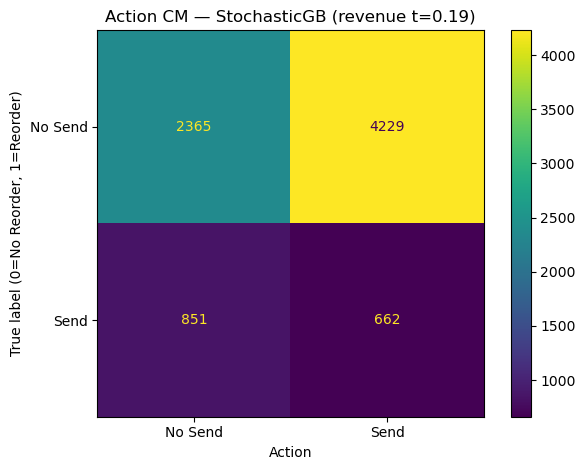

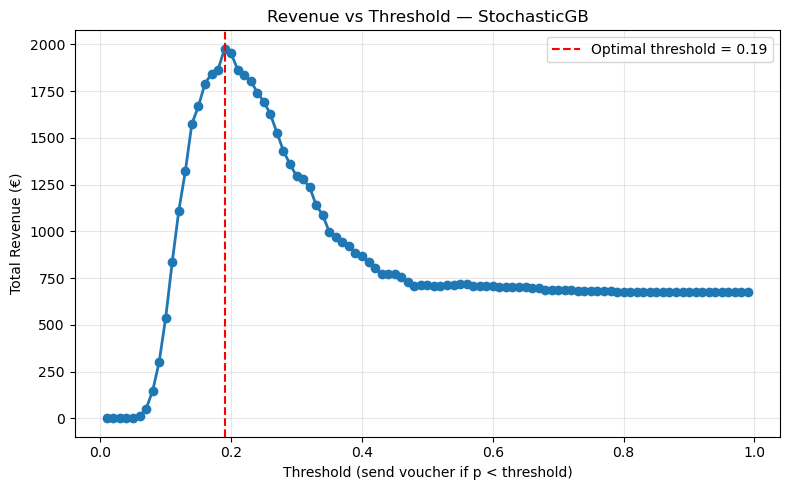

In [62]:
print("Training Stochastic GradientBoostingClassifier (subsample<1)...")

sgb = GradientBoostingClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE
)

result_sgb, model_sgb = evaluate_model(sgb, "StochasticGB", X_train_df, y_train, X_val_df, y_val)
models["StochasticGB"] = model_sgb
results.append(result_sgb)

print_and_plot_result(result_sgb, "StochasticGB")


### Interpretation of the confuison matrix for the Stochastic GB
0 = No reorder, 1 = reorder

**Interpretation of the action based CF**:

- 4229 are the correctly identified churners to whom we send a voucher
- 662 are the people that rebuy but we nevertheless send them vouchers
- 851 rebuy and we correctly do not send them vouchers 
- 2365 are churners we do not detect

Support: Shows us how many true examples of the class exist, both together should yield the test set 

Accuracy: shows that out of all predictions how many were correct

Precision: When the model predicts a class how often is it correct
When the model predicts buy again it is correct 26 % and when it predicts no reorder it is correct 86%.
Of all customers we predicted would reorder, only ~26% actually reordered.

Recall (Sensitivity): Out of all positives how many did we catch
We only correctly flagged  ~56% of the people who actually reorder. We flagged 64% of the people who do not reorder



## 5.7 AdaBoost

Training AdaBoost...

Training & Evaluating: AdaBoost
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.81      1.00      0.90      6594
     Reorder       0.00      0.00      0.00      1513

    accuracy                           0.81      8107
   macro avg       0.41      0.50      0.45      8107
weighted avg       0.66      0.81      0.73      8107

Default metrics -> Acc: 0.8134 | Prec(1): 0.0000 | Rec(1): 0.0000 | F1(1): 0.0000 | ROC-AUC: 0.6376

Revenue-optimized decision:
Best threshold (revenue): 0.2300
Send-rate @ best t: 0.547
Total Revenue @ best t: €1961.25
Average Revenue @ best t: €0.2419

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.87      0.59      0.70      6594
     Reorder       0.26      0.62      0.36      1513

    accuracy                           0.59      8107
   macro avg       0.56      0.60      0.53      810

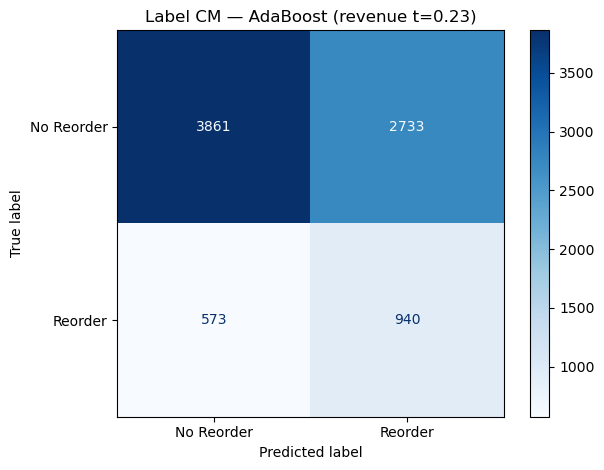

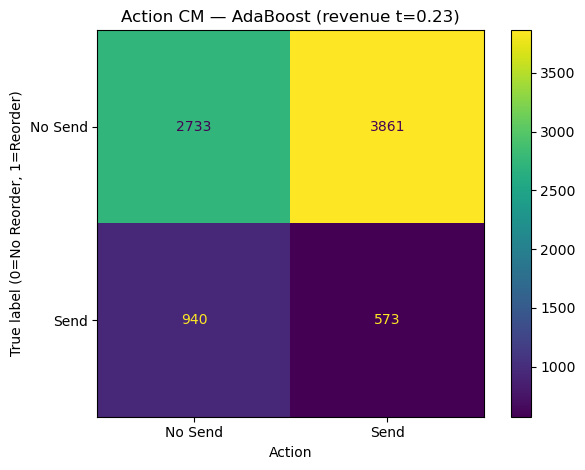

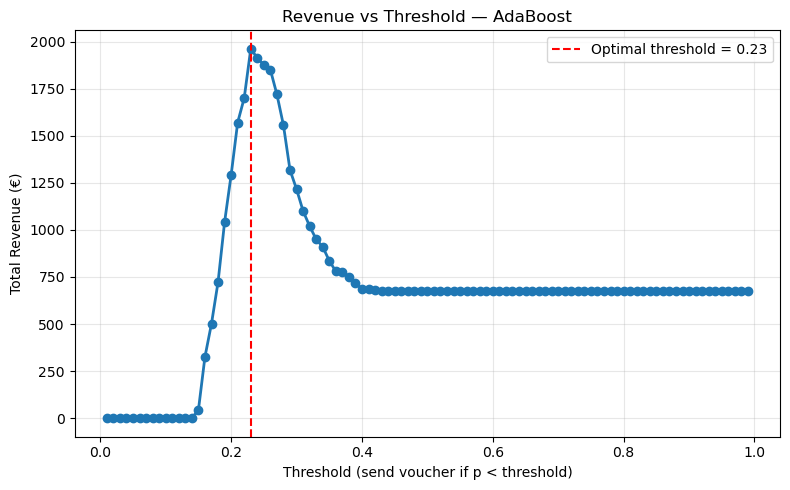

In [63]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

print("Training AdaBoost...")

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=2, random_state=RANDOM_STATE),
    n_estimators=500,
    learning_rate=0.05,
    random_state=RANDOM_STATE
)

result_ada, model_ada = evaluate_model(ada, "AdaBoost", X_train_df, y_train, X_val_df, y_val)
models["AdaBoost"] = model_ada
results.append(result_ada)

print_and_plot_result(result_ada, "AdaBoost")


### Interpretation of the confuison matrix for the AdaBoost

0 = No reorder, 1 = reorder

**Interpretation of the action based CF**:

- 3861 are the correctly identified churners to whom we send a voucher
- 573 are the people that rebuy but we nevertheless send them vouchers
- 940 rebuy and we correctly do not send them vouchers 
- 2733 are churners we do not detect

Support: Shows us how many true examples of the class exist, both together should yield the test set 

Accuracy: shows that out of all predictions 60% were correct

Precision: When the model predicts a class how often is it correct
When the model predicts buy again it is correct 26 % and when it predicts no reorder it is correct 87%.
Of all customers we predicted would reorder, only ~26% actually reordered.

Recall (Sensitivity): Out of all positives how many did we catch
We only correctly flagged  ~38% of the people who actually reorder. We flagged 41% of the people who do not reorder



## Comparison of all models

In [64]:
import pandas as pd
import numpy as np

rows = []
for r in results:
    rows.append({
        "model": r.get("model_name", "unknown"),
        "accuracy": r.get("accuracy", np.nan),
        "roc_auc": r.get("roc_auc", np.nan),
        "best_threshold": r.get("best_threshold", np.nan),
        "send_rate": r.get("send_rate", np.nan),
        "total_revenue": r.get("total_revenue", np.nan),
        "avg_revenue": r.get("avg_revenue", np.nan),
    })

cmp_df = pd.DataFrame(rows)

cmp_df = (cmp_df.sort_values("total_revenue", ascending=False)
                .drop_duplicates(subset=["model"], keep="first")
                .reset_index(drop=True))

cmp_df = cmp_df.sort_values("total_revenue", ascending=False).reset_index(drop=True)

display(cmp_df)


,model,accuracy,roc_auc,best_threshold,send_rate,total_revenue,avg_revenue
0,Gradient Boosting,0.813618,0.641848,0.20,0.653879,2020.00,0.249167
1,Random Forest,0.652152,0.639528,0.49,0.610213,1996.25,0.246238
2,HistGradientBoosting,0.813248,0.644074,0.21,0.681757,1996.25,0.246238
3,StochasticGB,0.812138,0.640675,0.19,0.603306,1976.25,0.243771
4,AdaBoost,0.813371,0.637565,0.23,0.546935,1961.25,0.241921
5,LightGBM,0.673492,0.619655,0.50,0.690638,1836.25,0.226502
6,Logistic Regression,0.601826,0.619666,0.51,0.617368,1668.75,0.205841
7,KNN,0.780683,0.554439,0.28,0.757000,1083.75,0.133681


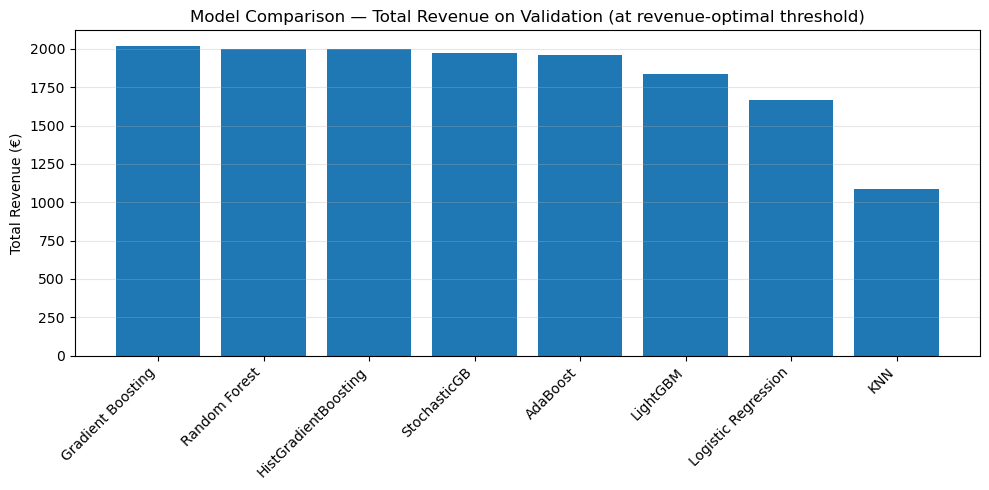

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(cmp_df["model"], cmp_df["total_revenue"])
plt.title("Model Comparison — Total Revenue on Validation (at revenue-optimal threshold)")
plt.ylabel("Total Revenue (€)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


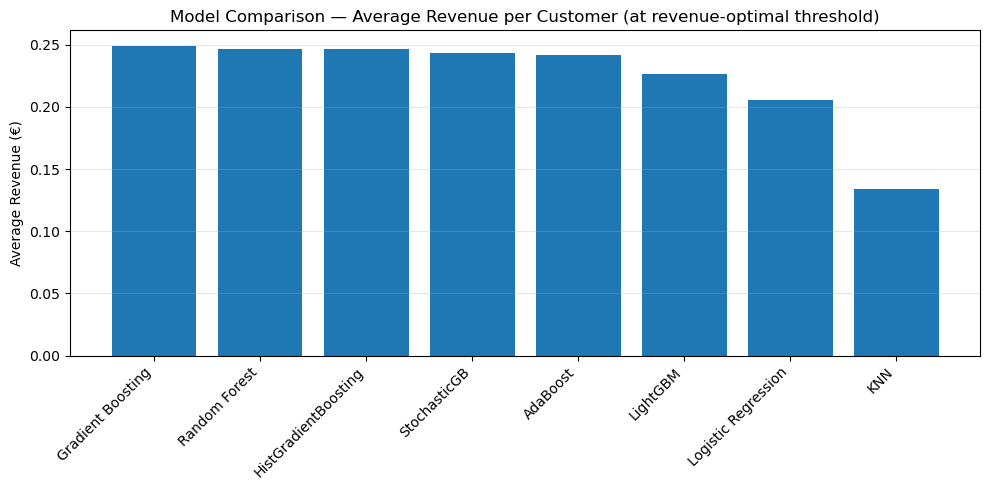

In [66]:
plt.figure(figsize=(10, 5))
plt.bar(cmp_df["model"], cmp_df["avg_revenue"])
plt.title("Model Comparison — Average Revenue per Customer (at revenue-optimal threshold)")
plt.ylabel("Average Revenue (€)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


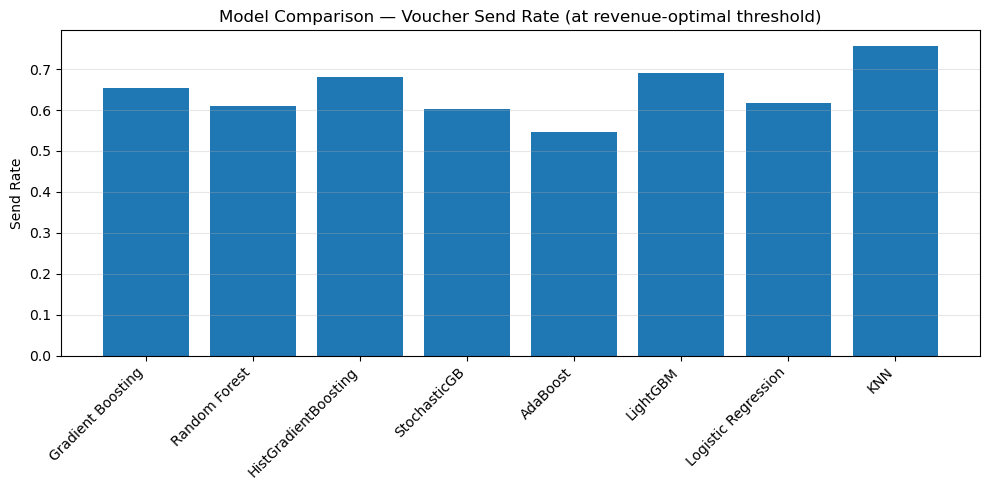

In [67]:
plt.figure(figsize=(10, 5))
plt.bar(cmp_df["model"], cmp_df["send_rate"])
plt.title("Model Comparison — Voucher Send Rate (at revenue-optimal threshold)")
plt.ylabel("Send Rate")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Hyperparamter tuning of the two best models 

We use a CV scorer that returns max avg revenue per fold (same idea as before) and run a small RandomizedSearchCV (faster and usually as good as grid).

In [68]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import numpy as np

def revenue_cv_scorer(estimator, X, y):
    if hasattr(estimator, "predict_proba"):
        p = estimator.predict_proba(X)[:, 1]
    elif hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
        p = 1 / (1 + np.exp(-s))
    else:
        p = estimator.predict(X).astype(float)

    p = np.clip(p, 0, 1)

    t_star, _, _ = optimize_threshold(y, p)
    _, avg_rev, _ = calculate_revenue(y, p, t_star)
    return avg_rev

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)


## 7.1 Tuning Random Forest


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

param_dist_rf = {
    "n_estimators": [200, 400, 600, 800, 1000],
    "max_depth": [None, 4, 6, 8, 10, 12, 16],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "max_features": ["sqrt", "log2", None, 0.3, 0.5, 0.7],
    "bootstrap": [True, False],
    "class_weight": [None, "balanced", "balanced_subsample"],
}

search_rf = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist_rf,
    n_iter=20,
    scoring=revenue_cv_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

search_rf.fit(X_train_df, y_train)

print("RF best CV avg revenue:", search_rf.best_score_)
print("RF best params:", search_rf.best_params_)

rf_tuned = search_rf.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
RF best CV avg revenue: 0.22902018831462523
RF best params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 0.5, 'max_depth': 10, 'class_weight': 'balanced_subsample', 'bootstrap': True}



Training & Evaluating: RandomForest_Tuned
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.86      0.68      0.76      6594
     Reorder       0.27      0.52      0.35      1513

    accuracy                           0.65      8107
   macro avg       0.56      0.60      0.56      8107
weighted avg       0.75      0.65      0.68      8107

Default metrics -> Acc: 0.6471 | Prec(1): 0.2684 | Rec(1): 0.5162 | F1(1): 0.3532 | ROC-AUC: 0.6410

Revenue-optimized decision:
Best threshold (revenue): 0.4800
Send-rate @ best t: 0.578
Total Revenue @ best t: €1971.25
Average Revenue @ best t: €0.2432

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.87      0.62      0.72      6594
     Reorder       0.26      0.59      0.36      1513

    accuracy                           0.61      8107
   macro avg       0.56      0.60      0.54      8107
weighted 

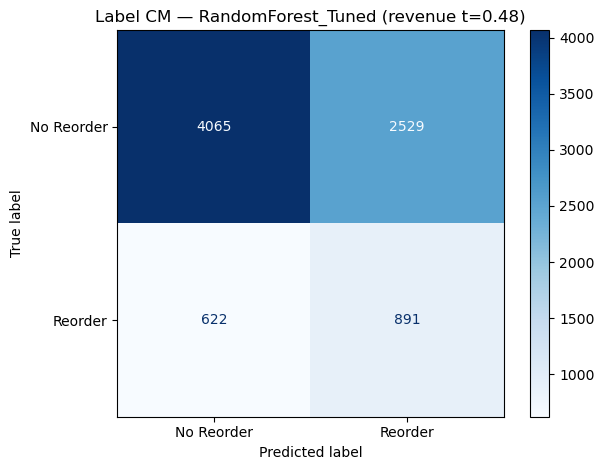

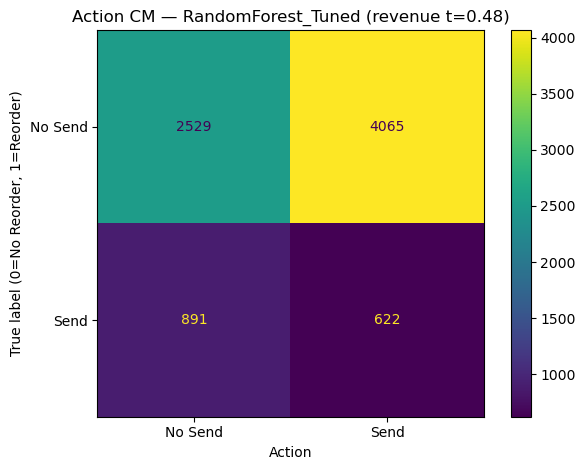

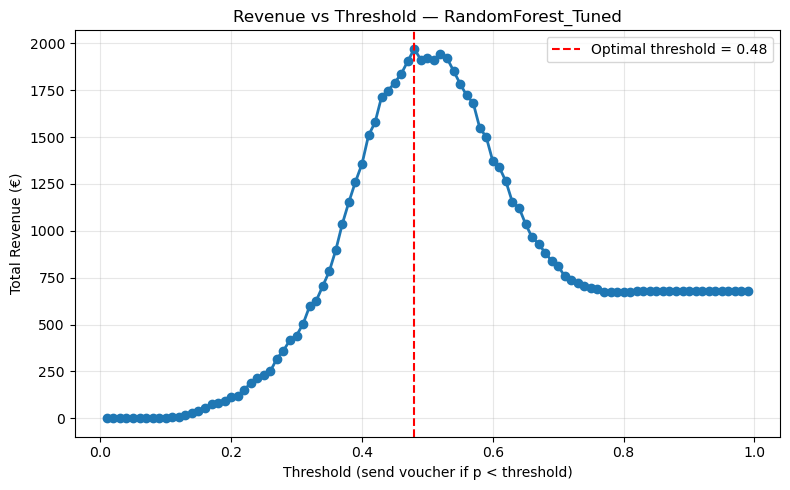

In [70]:
# I store the model 
res_rf_tuned, mdl_rf_tuned = evaluate_model(
    rf_tuned, "RandomForest_Tuned", X_train_df, y_train, X_val_df, y_val
)
models["RandomForest_Tuned"] = mdl_rf_tuned
results.append(res_rf_tuned)

print_and_plot_result(res_rf_tuned, "RandomForest_Tuned")



## Tune GB

In [71]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

gb_base = GradientBoostingClassifier(random_state=RANDOM_STATE)

param_dist_gb = {
    "n_estimators": [100, 200, 400, 600,800],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1],
    "max_depth": [2, 3, 4, 5],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10, 20],
    "subsample": [0.5, 0.6, 0.8, 1.0],      # makes it stochastic if < 1.0
    "max_features": [None, "sqrt", "log2"],
}

search_gb = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=param_dist_gb,
    n_iter=20,
    scoring=revenue_cv_scorer,
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

search_gb.fit(X_train_df, y_train)

print("GB best CV avg revenue:", search_gb.best_score_)
print("GB best params:", search_gb.best_params_)

gb_tuned = search_gb.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
GB best CV avg revenue: 0.23436536326631308
GB best params: {'subsample': 0.6, 'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 4, 'learning_rate': 0.01}



Training & Evaluating: GradientBoosting_Tuned
Default-threshold classification report:
              precision    recall  f1-score   support

  No Reorder       0.81      1.00      0.90      6594
     Reorder       0.58      0.00      0.01      1513

    accuracy                           0.81      8107
   macro avg       0.70      0.50      0.45      8107
weighted avg       0.77      0.81      0.73      8107

Default metrics -> Acc: 0.8136 | Prec(1): 0.5833 | Rec(1): 0.0046 | F1(1): 0.0092 | ROC-AUC: 0.6467

Revenue-optimized decision:
Best threshold (revenue): 0.2000
Send-rate @ best t: 0.655
Total Revenue @ best t: €2077.50
Average Revenue @ best t: €0.2563

Classification report at revenue-optimal threshold:
              precision    recall  f1-score   support

  No Reorder       0.86      0.69      0.77      6594
     Reorder       0.28      0.52      0.36      1513

    accuracy                           0.66      8107
   macro avg       0.57      0.61      0.57      8107
weigh

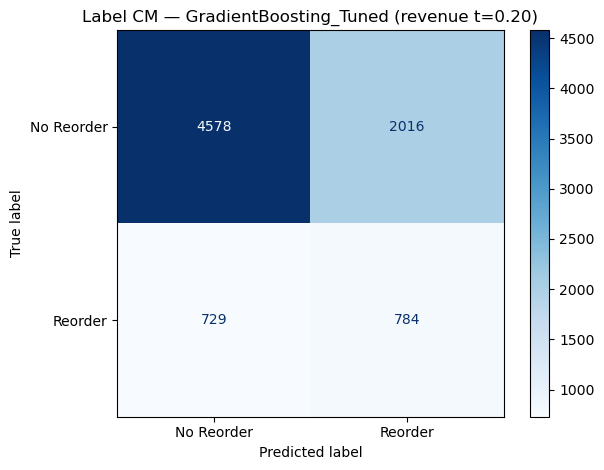

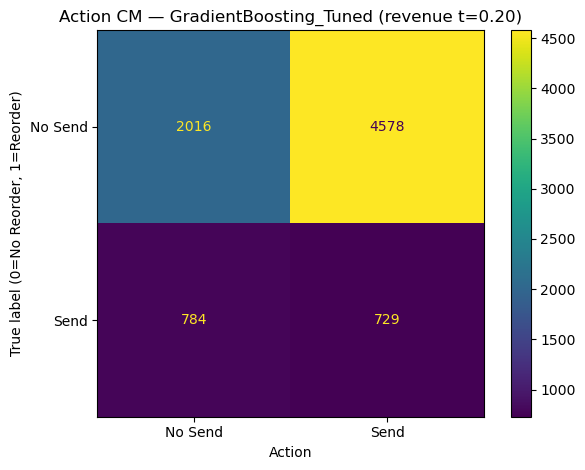

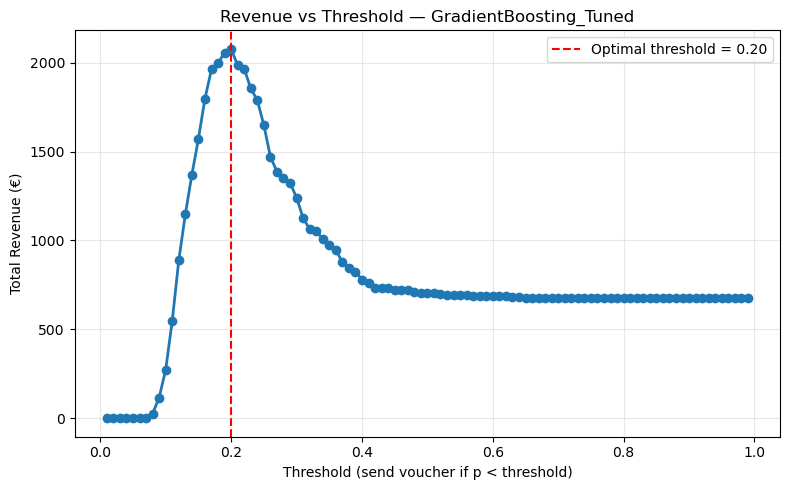

In [72]:
res_gb_tuned, mdl_gb_tuned = evaluate_model(
    gb_tuned, "GradientBoosting_Tuned", X_train_df, y_train, X_val_df, y_val
)
models["GradientBoosting_Tuned"] = mdl_gb_tuned
results.append(res_gb_tuned)

print_and_plot_result(res_gb_tuned, "GradientBoosting_Tuned")


## 8. Stacking

We start using probability averaging. 
I use the strongest and diverse 2-3 models.

- HistGradientBoosting

- StochasticGB (GradientBoosting with subsample)

- RandomForest (optional third)



In [73]:
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, HistGradientBoostingClassifier

base_models = {
    "GradientBoosting_Tuned": GradientBoostingClassifier(
        subsample=0.6,
        n_estimators=600,
        min_samples_split=5,
        min_samples_leaf=1,
        max_features=None,
        max_depth=4,
        learning_rate=0.01,
        random_state=RANDOM_STATE
    ),
    "RandomForest_Tuned": RandomForestClassifier(
        n_estimators=1000,
        min_samples_split=2,
        min_samples_leaf=20,
        max_features=0.5,
        max_depth=10,
        class_weight="balanced_subsample",
        bootstrap=True,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        max_depth=6,
        learning_rate=0.05,
        max_iter=400,
        random_state=RANDOM_STATE
    ),
}

fitted = {}
for name, m in base_models.items():
    fitted[name] = clone(m).fit(X_train_df, y_train)
    print("Fitted:", name)


Fitted: GradientBoosting_Tuned
Fitted: RandomForest_Tuned
Fitted: HistGradientBoosting


In [74]:
probas = []
for name, m in fitted.items():
    p = m.predict_proba(X_val_df)[:, 1]   # P(reorder=1)
    probas.append(p)

p_ens = np.mean(probas, axis=0)          # equal-weight average


In [75]:
best_t, best_rev, rev_curve = optimize_threshold(y_val, p_ens)
total_rev, avg_rev, send = calculate_revenue(y_val, p_ens, best_t)

print("Ensemble (avg probs) results")
print(f"Best threshold: {best_t:.4f}")
print(f"Send-rate: {send.mean():.3f}")
print(f"Total revenue: €{total_rev:.2f}")
print(f"Avg revenue: €{avg_rev:.4f}")


Ensemble (avg probs) results
Best threshold: 0.3000
Send-rate: 0.638
Total revenue: €2067.50
Avg revenue: €0.2550


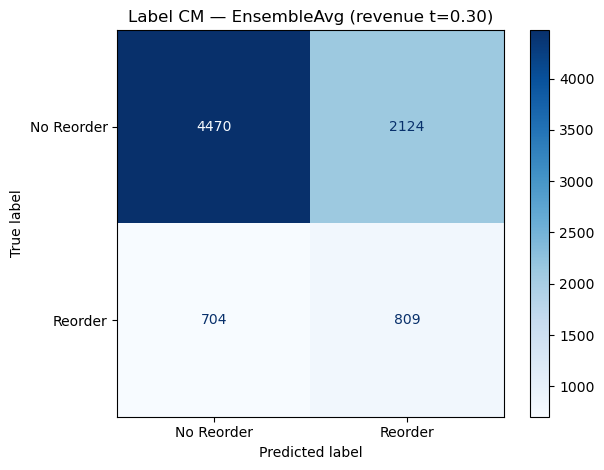

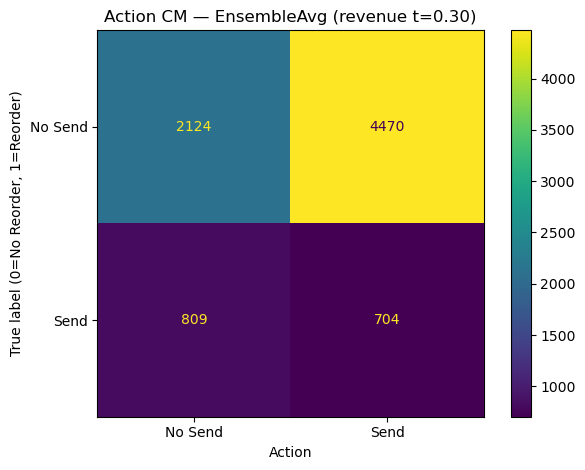

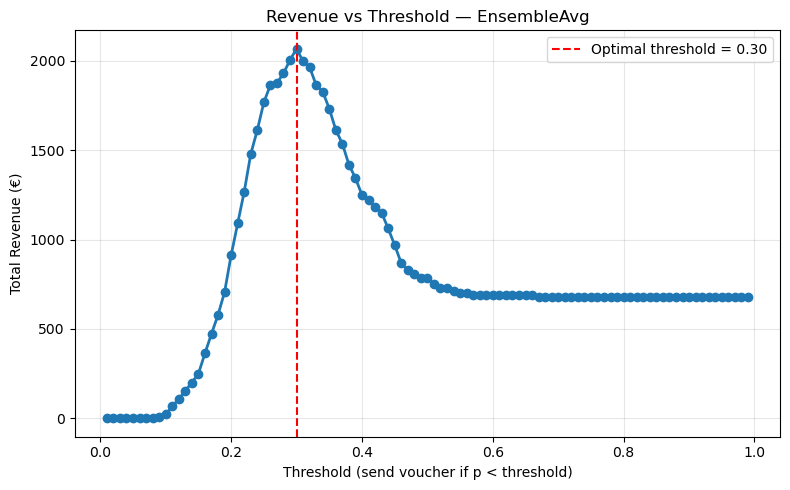

In [76]:
# Label predictions at best threshold
y_pred_best_t = (p_ens >= best_t).astype(int)
send_voucher  = (p_ens < best_t).astype(int)

plot_cm(y_val, y_pred_best_t, f"Label CM — EnsembleAvg (revenue t={best_t:.2f})")
plot_action_cm(y_val, send_voucher, f"Action CM — EnsembleAvg (revenue t={best_t:.2f})")

plt.figure(figsize=(8, 5))
plt.plot(rev_curve["threshold"], rev_curve["total_revenue"], marker="o", linewidth=2)
plt.axvline(best_t, color="red", linestyle="--", label=f"Optimal threshold = {best_t:.2f}")
plt.title("Revenue vs Threshold — EnsembleAvg")
plt.xlabel("Threshold (send voucher if p < threshold)")
plt.ylabel("Total Revenue (€)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [77]:
ensemble_result = {
    "model_name": "EnsembleAvg_3",
    "accuracy": accuracy_score(y_val, y_pred_best_t),
    "precision": precision_score(y_val, y_pred_best_t, zero_division=0),
    "recall": recall_score(y_val, y_pred_best_t, zero_division=0),
    "f1": f1_score(y_val, y_pred_best_t, zero_division=0),
    "roc_auc": roc_auc_score(y_val, p_ens),
    "report_default": classification_report(y_val, y_pred_best_t, target_names=["No Reorder","Reorder"], zero_division=0),
    "y_pred_default": y_pred_best_t,          # here “default” is not meaningful; but keep for schema
    "best_threshold": best_t,
    "total_revenue": total_rev,
    "avg_revenue": avg_rev,
    "send_rate": float(send_voucher.mean()),
    "y_pred_best_t": y_pred_best_t,
    "send_voucher": send_voucher,
    "y_proba": p_ens,
    "rev_curve": rev_curve,
}
results.append(ensemble_result)
print("Added ensemble to results.")


Added ensemble to results.


# Model comparison (again)

In [78]:
import pandas as pd
import numpy as np

# Build comparison table from results list
rows = []
for r in results:
    rows.append({
        "model": r.get("model_name", "unknown"),
        "accuracy": r.get("accuracy", np.nan),
        "roc_auc": r.get("roc_auc", np.nan),
        "best_threshold": r.get("best_threshold", np.nan),
        "send_rate": r.get("send_rate", np.nan),
        "total_revenue": r.get("total_revenue", np.nan),
        "avg_revenue": r.get("avg_revenue", np.nan),
    })

cmp_df = pd.DataFrame(rows)

# If you have duplicates (e.g., re-runs), keep the best by total revenue per model name
cmp_df = (cmp_df.sort_values("total_revenue", ascending=False)
                .drop_duplicates(subset=["model"], keep="first")
                .reset_index(drop=True))

# Sort for display (profit-first)
cmp_df = cmp_df.sort_values("total_revenue", ascending=False).reset_index(drop=True)

display(cmp_df)

,model,accuracy,roc_auc,best_threshold,send_rate,total_revenue,avg_revenue
0,GradientBoosting_Tuned,0.813618,0.646734,0.20,0.654619,2077.50,0.256260
1,EnsembleAvg_3,0.651166,0.646129,0.30,0.638214,2067.50,0.255027
2,Gradient Boosting,0.813618,0.641848,0.20,0.653879,2020.00,0.249167
3,Random Forest,0.652152,0.639528,0.49,0.610213,1996.25,0.246238
4,HistGradientBoosting,0.813248,0.644074,0.21,0.681757,1996.25,0.246238
5,StochasticGB,0.812138,0.640675,0.19,0.603306,1976.25,0.243771
6,RandomForest_Tuned,0.647095,0.641019,0.48,0.578142,1971.25,0.243154
7,AdaBoost,0.813371,0.637565,0.23,0.546935,1961.25,0.241921
8,LightGBM,0.673492,0.619655,0.50,0.690638,1836.25,0.226502
9,Logistic Regression,0.601826,0.619666,0.51,0.617368,1668.75,0.205841


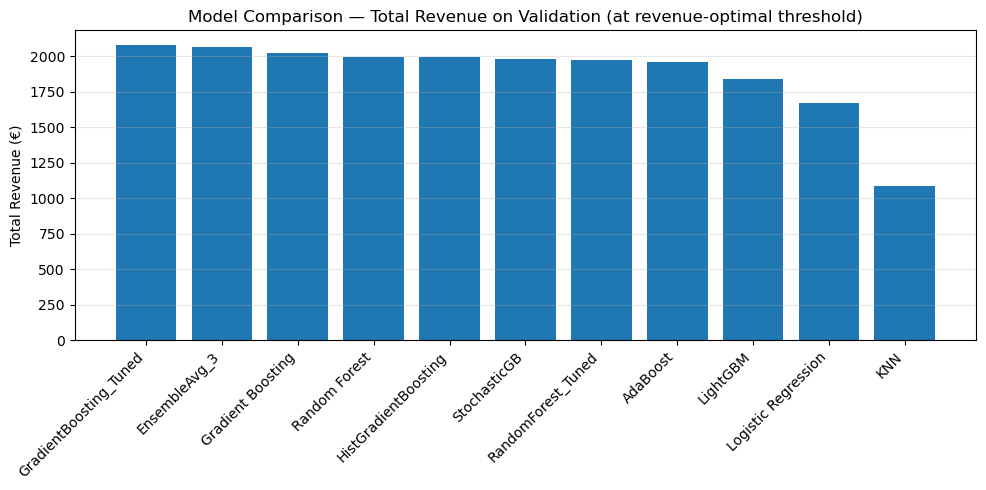

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(cmp_df["model"], cmp_df["total_revenue"])
plt.title("Model Comparison — Total Revenue on Validation (at revenue-optimal threshold)")
plt.ylabel("Total Revenue (€)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretable Machine Learning

In [80]:
model_explain = models["StochasticGB"]   # or "Gradient Boosting" if that's what you kept
model_name = "StochasticGB"

# Data used for explanations
X_bg = X_train_df.sample(n=min(1000, len(X_train_df)), random_state=RANDOM_STATE)   # background
X_exp = X_val_df.sample(n=min(2000, len(X_val_df)), random_state=RANDOM_STATE)      # explain sample

print("Explaining:", model_name)
print("Background:", X_bg.shape, "Explain:", X_exp.shape)


Explaining: StochasticGB
Background: (1000, 62) Explain: (2000, 62)


## Permutation feature importance

,feature,importance_mean,importance_std
3,remi,0.025806,0.002179
9,order_month,0.007630,0.001592
2,weight,0.005370,0.001177
43,newsletter_0,0.005366,0.001235
44,newsletter_1,0.005236,0.001337
15,w1,0.004498,0.001085
11,promised_delivery_month,0.004352,0.001650
7,account_age_days,0.003744,0.001069
52,deliverytype_0,0.003691,0.000759
55,voucher_1,0.003192,0.000679


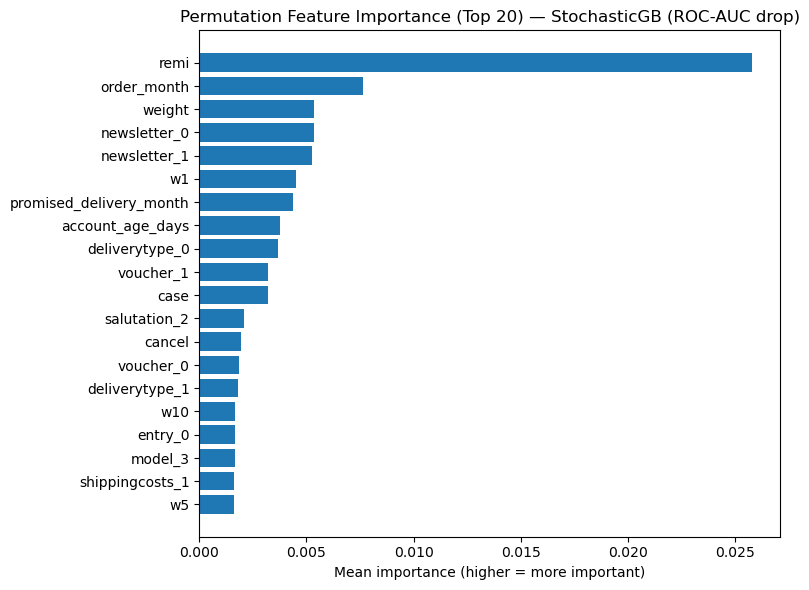

In [81]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    model_explain,
    X_val_df,
    y_val,
    scoring="roc_auc",
    n_repeats=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

imp_df = pd.DataFrame({
    "feature": X_val_df.columns,
    "importance_mean": perm.importances_mean,
    "importance_std": perm.importances_std
}).sort_values("importance_mean", ascending=False)

display(imp_df.head(20))

plt.figure(figsize=(8, 6))
top = imp_df.head(20).iloc[::-1]
plt.barh(top["feature"], top["importance_mean"])
plt.title(f"Permutation Feature Importance (Top 20) — {model_name} (ROC-AUC drop)")
plt.xlabel("Mean importance (higher = more important)")
plt.tight_layout()
plt.show()


For each feature I shuffle its values in the validation set and measure how much the models ROC-AUC drops. If ROC AUC drops a lot, the feature is important for ranking.

It is to be seen that : remi is clearly the strongest driver of ranking performance (biggest ROC-AUC drop).
Strong secondary drivers include: promised_delivery_month, order_month, newsletter_0/1, weight, w1, case, voucher_1, remi_rate.

Many of these are behavioral/order-content variables (returns/remissions, weight, item mix) and timing variables (order_month / promised_delivery_month).



## SHAP

In [82]:
import shap
import numpy as np

# TreeExplainer is fast and reliable for sklearn tree ensembles
explainer = shap.TreeExplainer(model_explain, data=X_bg, feature_perturbation="interventional")

# shap_values for binary classification sometimes returns list; we want class 1 = reorder
sv = explainer.shap_values(X_exp)
if isinstance(sv, list):
    sv = sv[1]  # class 1
sv = np.array(sv)

print("SHAP values shape:", sv.shape)


SHAP values shape: (2000, 62)


## SHAP feature importance plot 

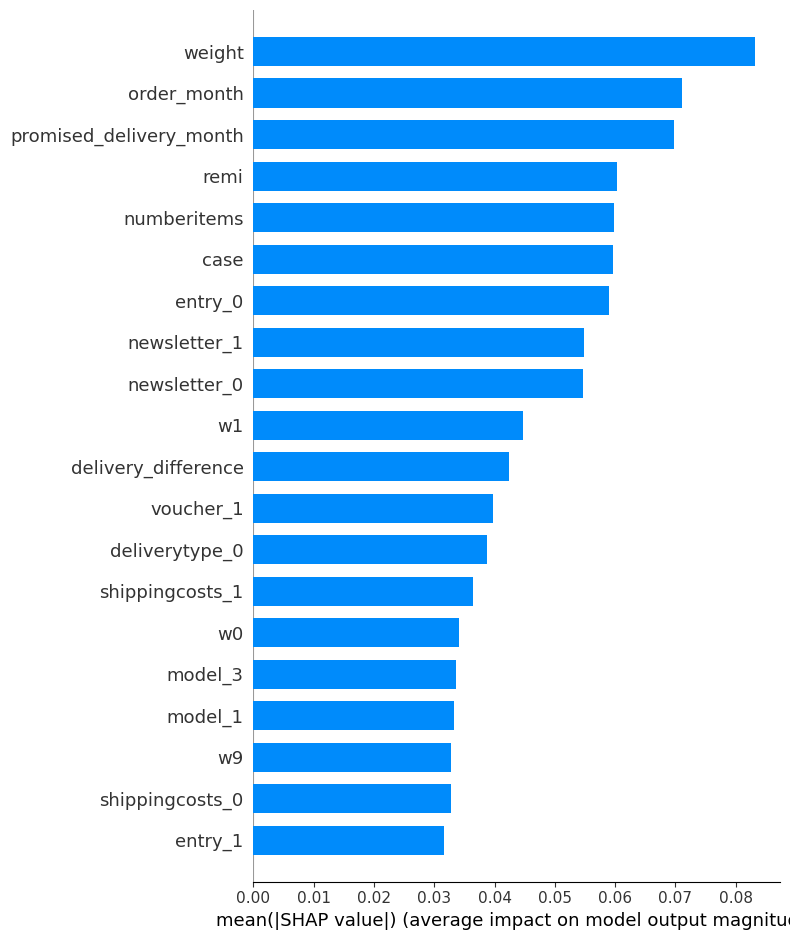

In [83]:
shap.summary_plot(sv, X_exp, plot_type="bar", show=True)


The mean absolute SHAP for each feature.
On average how much does this feature move the model output away from the baseline

The bigger the bar it indicates that the feature tends to have a large impact on predicted probabilities across many customers. 
Top drivers by SHAP magnitude:  promised_delivery_month, weight, order_month, entry_1, newsletter_0, numberitems, case, w1, newsletter_1, remi, voucher_1, delivery_difference.

SHAP indicates which variables most strongly shift predicted reorder probability for individual customers. Timing, shipment characteristics (weight), and basket structure (numberitems, product category indicators) dominate the model’s decision logic.



## SHAP dependence plots

In [84]:
mean_abs = np.abs(sv).mean(axis=0)
top_features = X_exp.columns[np.argsort(mean_abs)[::-1][:3]].tolist()
top_features


['weight', 'order_month', 'promised_delivery_month']

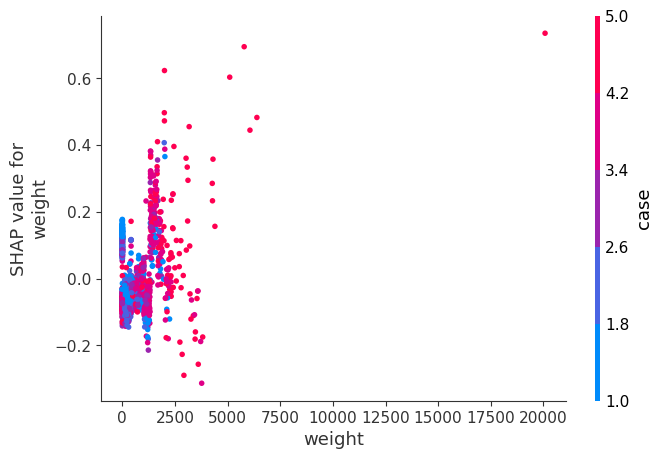

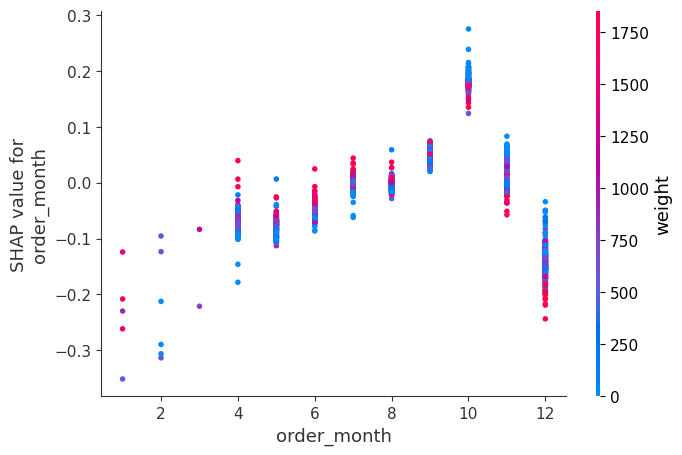

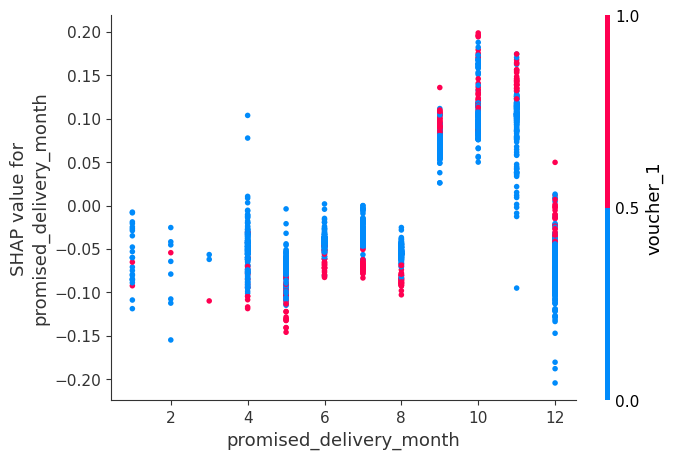

In [85]:
for f in top_features:
    shap.dependence_plot(f, sv, X_exp, show=True)


## Local explanations (Waterfall plot)

Example customer: p(reorder)=0.142 < t=0.19 -> SEND voucher


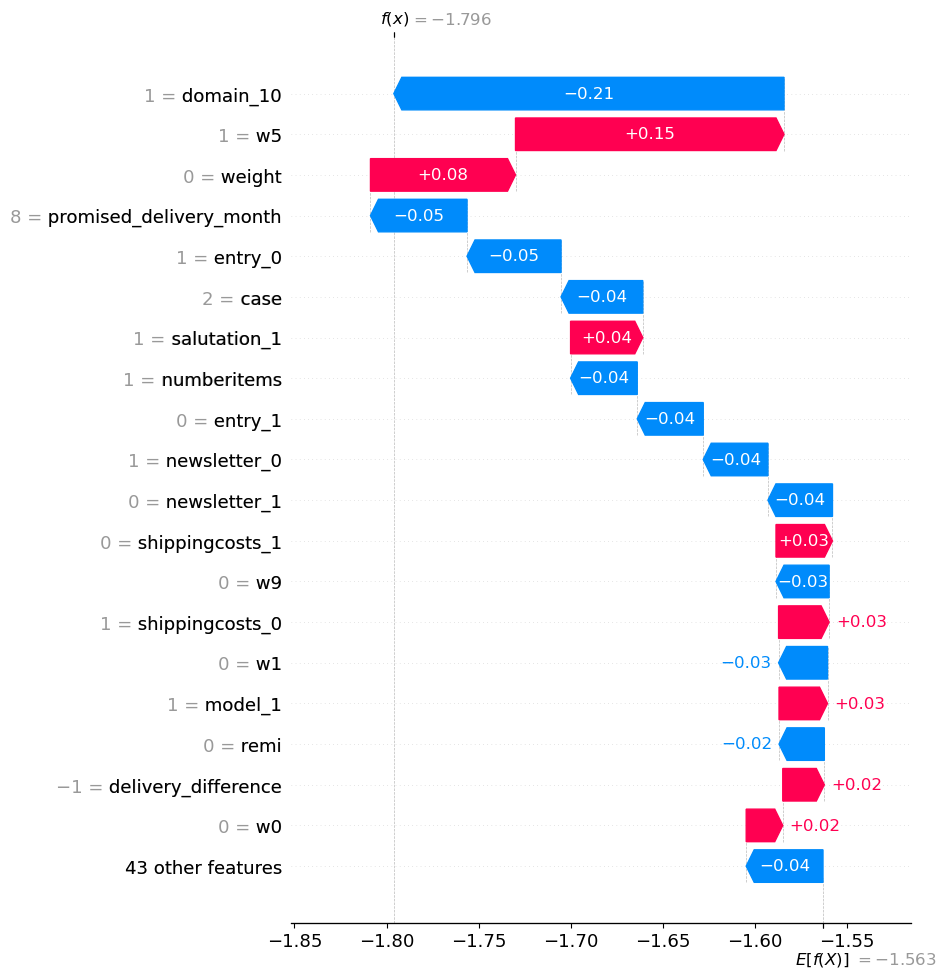

In [86]:
t_star = None
for r in results:
    if r["model_name"] == model_name:
        t_star = r["best_threshold"]
        break
if t_star is None:
    t_star = 0.20  # fallback if not found

p_all = model_explain.predict_proba(X_val_df)[:, 1]
send_mask = p_all < t_star

idx_send = X_val_df.index[np.where(send_mask)[0][0]]
x1 = X_val_df.loc[[idx_send]]

p1 = model_explain.predict_proba(x1)[:, 1][0]
print(f"Example customer: p(reorder)={p1:.3f} < t={t_star:.2f} -> SEND voucher")

sv1 = explainer.shap_values(x1)
if isinstance(sv1, list):
    sv1 = sv1[1]
sv1 = np.array(sv1).reshape(-1)

base = explainer.expected_value
if isinstance(base, (list, np.ndarray)):
    base = base[1] if len(base) > 1 else base[0]

exp = shap.Explanation(values=sv1, base_values=base, data=x1.iloc[0], feature_names=x1.columns)
shap.plots.waterfall(exp, max_display=20)


For this single instance domain is the strongest driver down. Being in this particular domain category is associated (in the model) with lower reorder likelihood for this customer.
Timing and entry status are also pulling the score down.
The strongest upward push is w5. This product-category signal is associated with higher reorder likelihood.
Moreover weight = 0 pushes the likelihood to rebuy higher for this customer

## Predictions for the test set

In [87]:
final_model = models["HistGradientBoosting"]   
final_threshold = 0.19                         

print("Final model:", type(final_model).__name__)
print("Final threshold:", final_threshold)


Final model: HistGradientBoostingClassifier
Final threshold: 0.19


In [88]:
X_full = pd.concat([X_train_df, X_val_df], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

final_model.fit(X_full, y_full)
print("Refit done. Full data shape:", X_full.shape)


Refit done. Full data shape: (32428, 62)


In [89]:
p_test = final_model.predict_proba(X_test_df)[:, 1]     
send_voucher = (p_test < final_threshold).astype(int)    

print("Test send-rate:", send_voucher.mean())


Test send-rate: 0.579455392111512


In [90]:
submission = pd.DataFrame({
    "customernumber": test["customernumber"].values,
    "send_voucher": send_voucher
})

submission.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv with columns:", submission.columns.tolist())
submission.head()


Saved test_predictions.csv with columns: ['customernumber', 'send_voucher']


,customernumber,send_voucher
0,6044,1
1,36314,0
2,41932,0
3,3194,1
4,35363,1
